# PCA y K-Means

## Preprocesamiento

### Librerías

In [352]:
import pyodbc
import pandas as pd
import numpy as np
import os
import logging
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

### Conexión a Azure

In [353]:
import os
import logging
import pandas as pd
import pyodbc
from functools import reduce

# Configura logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuración de conexión
AZURE_SERVER = 'uaxmathfis.database.windows.net'
AZURE_DATABASE = 'usecases'
AZURE_DRIVER = '{ODBC Driver 17 for SQL Server}'
CSV_PATH = 'datos.csv'

def get_azure_connection():
    """Establece conexión con Azure SQL usando autenticación interactiva"""
    conn_str = f"DRIVER={AZURE_DRIVER};SERVER={AZURE_SERVER};DATABASE={AZURE_DATABASE};Authentication=ActiveDirectoryInteractive"
    try:
        conn = pyodbc.connect(conn_str)
        logging.info("Conexión exitosa a Azure SQL")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión: {e}")
        return None

def download_and_combine_tables():
    """Descarga todas las tablas y las combina correctamente por ID"""
    if os.path.exists(CSV_PATH):
        try:
            os.remove(CSV_PATH)
            logging.info(f"Archivo existente {CSV_PATH} eliminado")
        except Exception as e:
            logging.error(f"No se pudo eliminar {CSV_PATH}: {e}")

    queries = {
        'IA_Client_Segment_MODIFICADO': "SELECT * FROM DATAEX.IA_Client_Segment_MODIFICADO"
    }

    conn = get_azure_connection()
    if not conn:
        return pd.DataFrame()

    try:
        dfs = {}
        for name, query in queries.items():
            try:
                df = pd.read_sql(query, conn)
                logging.info(f"Tabla {name} descargada con {len(df)} registros")

                if 'ID' not in df.columns:
                    logging.warning(f"La tabla {name} no contiene columna 'ID'")
                    continue

                df['ID'] = df['ID'].astype(str)
                df = df.dropna(subset=['ID'])
                df = df.drop_duplicates(subset=['ID'])

                dfs[name] = df.set_index('ID')

            except Exception as e:
                logging.error(f"Error procesando {name}: {e}")

        if dfs:
            combined = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), dfs.values())
            combined.to_csv(CSV_PATH)
            logging.info(f"Nuevo archivo {CSV_PATH} creado con {len(combined)} registros combinados")
            return combined
        else:
            logging.warning("No se descargaron datos válidos")
            return pd.DataFrame()

    finally:
        conn.close()

def load_from_csv():
    """Carga los datos previamente guardados desde el CSV"""
    try:
        if os.path.exists(CSV_PATH):
            return pd.read_csv(CSV_PATH, index_col='ID')
        else:
            logging.warning(f"Archivo {CSV_PATH} no encontrado")
            return pd.DataFrame()
    except Exception as e:
        logging.error(f"Error cargando CSV: {e}")
        return pd.DataFrame()

# Ejecutar la descarga
# df = download_and_combine_tables()

# Alternativamente, para cargar desde el CSV si ya existe:
df_original = load_from_csv()

if not df_original.empty:
    print("\nDatos combinados correctamente:")
    print(f"Total de registros: {len(df)}")
    print(f"Columnas: {len(df.columns)}")
    print(df_original.head())
else:
    print("No hay datos disponibles")


Datos combinados correctamente:
Total de registros: 10806
Columnas: 18
         Genero Casado  Edad Graduado    Profesion Experiencia_laboral  \
ID                                                                       
CLI10         F     Si    67       Si    Ingeniero            +20annos   
CLI100        M     Si    64       Si       Medico            +20annos   
CLI1000       M     Si    65       Si      Artista            +20annos   
CLI10000      M     No    33       No  Funcionario          10-20annos   
CLI10001      M     Si    52       No        Otros            +20annos   

         Gastoscore  Family_Size  anno_nacimiento    Generacion  \
ID                                                                
CLI10          Bajo            3             1957  Generacion X   
CLI100        Medio            2             1960  Generacion X   
CLI1000       Medio            3             1959  Generacion X   
CLI10000       Bajo            4             1991   Millennials   
CLI1000

### Datos

In [354]:
df = df_original.copy()
df_original

Genero Casado  Edad Graduado    Profesion Experiencia_laboral  \
ID                                                                       
CLI10         F     Si    67       Si    Ingeniero            +20annos   
CLI100        M     Si    64       Si       Medico            +20annos   
CLI1000       M     Si    65       Si      Artista            +20annos   
CLI10000      M     No    33       No  Funcionario          10-20annos   
CLI10001      M     Si    52       No        Otros            +20annos   
...         ...    ...   ...      ...          ...                 ...   
CLI9995       F     Si    76       No    Servicios            +20annos   
CLI9996       F     No    44       Si  Funcionario            +20annos   
CLI9997       M     Si    47       Si    Ejecutivo            +20annos   
CLI9998       M     Si    40       Si      Artista          10-20annos   
CLI9999       M     Si    39       Si        Otros          10-20annos   

         Gastoscore  Family_Size  anno_nacimiento    Generacion  \
ID                                                                
CLI10          Bajo            3             1957  Generacion X   
CLI100        Medio            2             1960  Generacion X   
CLI1000       Medio            3             1959  Generacion X   
CLI10000       Bajo            4             1991   Millennials   
CLI10001      Medio            2             1972  Generacion X   
...             ...          ...              ...           ...   
CLI9995        Alto            2             1948  Generacion X   
CLI9996        Bajo            1             1980  Generacion X   
CLI9997        Alto            3             1977  Generacion X   
CLI9998        Alto            3             1984   Millennials   
CLI9999       Medio            2             1985   Millennials   

          Ingresos_anuales_brutos    Provincia  Digital_encuesta  \
ID                                                                 
CLI10                       93442      Segovia            1385.0   
CLI100                      99774     Alicante            1052.0   
CLI1000                     36756       Toledo            1717.0   
CLI10000                    24616         Leon            1606.0   
CLI10001                    29834       LLeida            1346.0   
...                           ...          ...               ...   
CLI9995                     33389       Toledo            1424.0   
CLI9996                     76067      Cordoba            1514.0   
CLI9997                     61300         Lugo            1385.0   
CLI9998                    106015       Cuenca            1974.0   
CLI9999                     27169  Guadalajara            1951.0   

          Gasto_medio_mensual_cuota  Abandono  Dias_cliente  Campanna_anno  
ID                                                                          
CLI10                            80      True           195            NaN  
CLI100                           50      True           360            5.0  
CLI1000                          30     False           407            3.0  
CLI10000                         30     False           544            4.0  
CLI10001                         30      True           170            NaN  
...                             ...       ...           ...            ...  
CLI9995                          30      True           106            NaN  
CLI9996                          50     False           257            NaN  
CLI9997                          80      True           347            5.0  
CLI9998                          30     False           582            1.0  
CLI9999                          30     False           460            3.0  

[10806 rows x 17 columns]

## Procesamiento

### Zonas geográficas

In [355]:
print(df['Provincia'].value_counts())

Provincia
Madrid                    326
Jaen                      252
Gerona                    248
Leon                      239
La Rioja                  237
Almeri­a                  234
Santa Cruz de Tenerife    229
Zamora                    227
Alicante                  227
ivila                    226
Granada                   226
Valladolid                225
Sevilla                   225
Vizcaya                   224
Las Palmas                223
Valencia                  223
Teruel                    222
Toledo                    219
Cadiz                     219
Ceuta                     218
Guadalajara               217
Palencia                  217
Tarragona                 216
Segovia                   215
Guipiºzcoa                214
Albacete                  214
Malaga                    214
Orense                    214
Badajoz                   214
Navarra                   212
Caceres                   211
Pontevedra                210
Burgos                    210


In [356]:
# Diccionario para reemplazar nombres mal codificados
reemplazos = {
    'ivila': 'Ávila',
    'ilava': 'Álava',
    'Guipiºzcoa': 'Guipúzcoa',
    'Almeri­a': 'Almería',
    'La Corui±a': 'La Coruña',
    'LLeida': 'Lleida',
    'Cadiz': 'Cádiz',
    'Cordoba': 'Córdoba',
    'Malaga': 'Málaga',
    'Jaen': 'Jaén',
    'Leon': 'León',
    'Castellon': 'Castellón'
}

# Aplicar reemplazo en la columna Provincia
df['Provincia'] = df['Provincia'].replace(reemplazos)

norte = ['La Coruña', 'Lugo', 'Orense', 'Pontevedra', 'Vizcaya', 'Guipúzcoa', 'Álava', 'Navarra', 'La Rioja', 'Burgos', 'Soria', 'León', 'Huesca', 'Zaragoza']
sur = ['Almería', 'Cádiz', 'Córdoba', 'Granada', 'Huelva', 'Jaén', 'Málaga', 'Sevilla', 'Ceuta', 'Melilla']
este = ['Barcelona', 'Gerona', 'Lleida', 'Tarragona', 'Castellón', 'Valencia', 'Alicante', 'Murcia', 'Baleares', 'Teruel']
oeste = ['Caceres', 'Badajoz', 'Salamanca', 'Zamora']
centro = ['Madrid', 'Guadalajara', 'Toledo', 'Cuenca', 'Ciudad Real', 'Ávila', 'Segovia', 'Valladolid', 'Palencia', 'Albacete']
islas = ['Las Palmas', 'Santa Cruz de Tenerife']

def asignar_region(provincia):
    if provincia in norte:
        return 'Norte'
    elif provincia in sur:
        return 'Sur'
    elif provincia in este:
        return 'Este'
    elif provincia in oeste:
        return 'Oeste'
    elif provincia in centro:
        return 'Centro'
    elif provincia in islas:
        return 'Islas'
    else:
        return 'Desconocido'

df['Region'] = df['Provincia'].apply(asignar_region)

### Rellenar valores faltantes

In [357]:
# Mostrar valores faltantes
print("\nValores faltantes por columna:")
print(df.isna().sum()[df.isna().sum() > 0])


Valores faltantes por columna:
Casado            190
Graduado          103
Campanna_anno    5707
dtype: int64


In [358]:
import pandas as pd
from sklearn.impute import SimpleImputer

# 1. Casado y Graduado → Imputar con la moda
imputer_mode = SimpleImputer(strategy='most_frequent')
df[['Casado', 'Graduado']] = imputer_mode.fit_transform(df[['Casado', 'Graduado']])

# 2. Generacion → Calcular a partir del año de nacimiento
def generar_generacion(anio):
    if anio >= 1997:
        return 4  # Generacion Z
    elif anio >= 1981 & anio <= 1996:
        return 3  # Millennials
    elif anio >= 1965 & anio <= 1980:
        return 2  # Generacion X
    elif anio >= 1946 & anio <= 1964:
        return 1  # Baby Boomers
    elif anio <= 1945:
        return 0 # Generacion Silenciosa 

df['Generacion'] = df.apply(
    lambda row: row['Generacion'] if pd.notna(row['Generacion']) else generar_generacion(row['anno_nacimiento']),
    axis=1
)

# 3. Campanna_anno → Imputar con -1 (representa valor faltante de forma explícita)
df['Campanna_anno'] = df['Campanna_anno'].fillna(-1)

In [359]:
# Mostrar valores faltantes
print("\nValores faltantes por columna:")
print(df.isna().sum()[df.isna().sum() > 0])


Valores faltantes por columna:
Series([], dtype: int64)


In [360]:
df_sin_na = df.copy()
df_sin_na

Genero Casado  Edad Graduado    Profesion Experiencia_laboral  \
ID                                                                       
CLI10         F     Si    67       Si    Ingeniero            +20annos   
CLI100        M     Si    64       Si       Medico            +20annos   
CLI1000       M     Si    65       Si      Artista            +20annos   
CLI10000      M     No    33       No  Funcionario          10-20annos   
CLI10001      M     Si    52       No        Otros            +20annos   
...         ...    ...   ...      ...          ...                 ...   
CLI9995       F     Si    76       No    Servicios            +20annos   
CLI9996       F     No    44       Si  Funcionario            +20annos   
CLI9997       M     Si    47       Si    Ejecutivo            +20annos   
CLI9998       M     Si    40       Si      Artista          10-20annos   
CLI9999       M     Si    39       Si        Otros          10-20annos   

         Gastoscore  Family_Size  anno_nacimiento    Generacion  \
ID                                                                
CLI10          Bajo            3             1957  Generacion X   
CLI100        Medio            2             1960  Generacion X   
CLI1000       Medio            3             1959  Generacion X   
CLI10000       Bajo            4             1991   Millennials   
CLI10001      Medio            2             1972  Generacion X   
...             ...          ...              ...           ...   
CLI9995        Alto            2             1948  Generacion X   
CLI9996        Bajo            1             1980  Generacion X   
CLI9997        Alto            3             1977  Generacion X   
CLI9998        Alto            3             1984   Millennials   
CLI9999       Medio            2             1985   Millennials   

          Ingresos_anuales_brutos    Provincia  Digital_encuesta  \
ID                                                                 
CLI10                       93442      Segovia            1385.0   
CLI100                      99774     Alicante            1052.0   
CLI1000                     36756       Toledo            1717.0   
CLI10000                    24616         León            1606.0   
CLI10001                    29834       Lleida            1346.0   
...                           ...          ...               ...   
CLI9995                     33389       Toledo            1424.0   
CLI9996                     76067      Córdoba            1514.0   
CLI9997                     61300         Lugo            1385.0   
CLI9998                    106015       Cuenca            1974.0   
CLI9999                     27169  Guadalajara            1951.0   

          Gasto_medio_mensual_cuota  Abandono  Dias_cliente  Campanna_anno  \
ID                                                                           
CLI10                            80      True           195           -1.0   
CLI100                           50      True           360            5.0   
CLI1000                          30     False           407            3.0   
CLI10000                         30     False           544            4.0   
CLI10001                         30      True           170           -1.0   
...                             ...       ...           ...            ...   
CLI9995                          30      True           106           -1.0   
CLI9996                          50     False           257           -1.0   
CLI9997                          80      True           347            5.0   
CLI9998                          30     False           582            1.0   
CLI9999                          30     False           460            3.0   

          Region  
ID                
CLI10     Centro  
CLI100      Este  
CLI1000   Centro  
CLI10000   Norte  
CLI10001    Este  
...          ...  
CLI9995   Centro  
CLI9996      Sur  
CLI9997    Norte  
CLI9998   Centro  
CLI9999   Centro  

[10806 rows x 18 columns]

### Transformación a numéricas

In [361]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1. Binarias
bin_map = {
    'Genero': {'F': 0, 'M': 1},
    'Casado': {'No': 0, 'Si': 1},
    'Graduado': {'No': 0, 'Si': 1},
    'Abandono': {False: 0, True: 1}
}
for col, mapping in bin_map.items():
    df[col] = df[col].map(mapping)

# 2. Ordinales con orden definido
df['Experiencia_laboral'] = df['Experiencia_laboral'].map({
    '<10annos': 0, '10-20annos': 1, '+20annos': 2
})

df['Gastoscore'] = df['Gastoscore'].map({
    'Bajo': 0, 'Medio': 1, 'Alto': 2
})

df['Generacion'] = df['Generacion'].map({
    'Generacion Silenciosa':0, 'Baby Boomers': 1, 'Generacion X': 2, 'Millennials': 3, 'Generacion Z': 4
})

df['Campanna_anno'] = pd.to_numeric(df['Campanna_anno'], errors='coerce')

# 3. Nominales sin orden
le_dict = {}
for col in ['Profesion', 'Provincia']:
    df[col] = df[col].astype(str).str.strip()
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# 4. Forzar columnas numéricas
num_cols = ['Edad', 'Family_Size', 'anno_nacimiento',
            'Ingresos_anuales_brutos', 'Digital_encuesta',
            'Gasto_medio_mensual_cuota', 'Dias_cliente']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Codificar la columna 'Region' como nominal sin orden
le_region = LabelEncoder()
df['Region'] = df['Region'].astype(str).str.strip()
df['Region'] = le_region.fit_transform(df['Region'])

### Datos procesados

In [362]:
df

Genero  Casado  Edad  Graduado  Profesion  Experiencia_laboral  \
ID                                                                         
CLI10          0       1    67         1          4                    2   
CLI100         1       1    64         1          5                    2   
CLI1000        1       1    65         1          0                    2   
CLI10000       1       0    33         0          3                    1   
CLI10001       1       1    52         0          7                    2   
...          ...     ...   ...       ...        ...                  ...   
CLI9995        0       1    76         0          8                    2   
CLI9996        0       0    44         1          3                    2   
CLI9997        1       1    47         1          2                    2   
CLI9998        1       1    40         1          0                    1   
CLI9999        1       1    39         1          7                    1   

          Gastoscore  Family_Size  anno_nacimiento  Generacion  \
ID                                                               
CLI10              0            3             1957           2   
CLI100             1            2             1960           2   
CLI1000            1            3             1959           2   
CLI10000           0            4             1991           3   
CLI10001           1            2             1972           2   
...              ...          ...              ...         ...   
CLI9995            2            2             1948           2   
CLI9996            0            1             1980           2   
CLI9997            2            3             1977           2   
CLI9998            2            3             1984           3   
CLI9999            1            2             1985           3   

          Ingresos_anuales_brutos  Provincia  Digital_encuesta  \
ID                                                               
CLI10                       93442         37            1385.0   
CLI100                      99774          1            1052.0   
CLI1000                     36756         42            1717.0   
CLI10000                    24616         24            1606.0   
CLI10001                    29834         25            1346.0   
...                           ...        ...               ...   
CLI9995                     33389         42            1424.0   
CLI9996                     76067         13            1514.0   
CLI9997                     61300         26            1385.0   
CLI9998                    106015         11            1974.0   
CLI9999                     27169         16            1951.0   

          Gasto_medio_mensual_cuota  Abandono  Dias_cliente  Campanna_anno  \
ID                                                                           
CLI10                            80         1           195           -1.0   
CLI100                           50         1           360            5.0   
CLI1000                          30         0           407            3.0   
CLI10000                         30         0           544            4.0   
CLI10001                         30         1           170           -1.0   
...                             ...       ...           ...            ...   
CLI9995                          30         1           106           -1.0   
CLI9996                          50         0           257           -1.0   
CLI9997                          80         1           347            5.0   
CLI9998                          30         0           582            1.0   
CLI9999                          30         0           460            3.0   

          Region  
ID                
CLI10          0  
CLI100         1  
CLI1000        0  
CLI10000       3  
CLI10001       1  
...          ...  
CLI9995        0  
CLI9996        5  
CLI9997        3  
CLI9998        0  
CLI9999        0  

[10806 rows x 18 columns]

### Clasificación de columnas según tipo de transformación

**1. Variables Binarias (se convierten a 0 y 1)**

| Columna    | Valor 0 | Valor 1 |
|------------|---------|---------|
| Genero     | F       | M       |
| Casado     | No      | Si      |
| Graduado   | No      | Si      |
| Abandono   | False   | True    |



**2. Variables Ordinales (ordenadas de menor a mayor)**


a. Experiencia Laboral


| Valor Original | Codificado |
|----------------|------------|
| <10annos       | 0          |
| 10-20annos     | 1          |
| +20annos       | 2          |

b. Gastoscore


| Valor Original | Codificado |
|----------------|------------|
| Bajo           | 0          |
| Medio          | 1          |
| Alto           | 2          |

c. Generación


| Valor Original     | Codificado |
|--------------------|------------|
| Gen Silenciosa     | 0          |
| Baby Boomers       | 1          |
| Generacion X       | 2          |
| Millennials        | 3          |
| Generacion Z       | 4          |

d. Campanna_anno
- Se convierte directamente a número (`float`) para conservar orden.


**3. Variables Categóricas Nominales (sin orden)**

Estas se convierten con **Label Encoding**, el orden **no importa**.  
Guarda el diccionario generado para comprobarlo.

- **Provincia**
- **Profesion**

*Ejemplo de cómo imprimir equivalencias:*

```python
pd.Series(le_dict['Provincia'])  # para ver las provincias y su código
pd.Series(le_dict['Profesion'])  # para ver profesiones y su código


## PCA y K-Means: Prueba

### Flags

In [363]:
# Flags para activar o desactivar columnas específicas
flags = {
    "ID": False,
    "Genero": True,
    "Casado": True,
    "Edad": True,
    "Graduado": True,
    "Profesion": True,
    "Experiencia_laboral": True,
    "Gastoscore": True,
    "Family_Size": True,
    "anno_nacimiento": True,
    "Generacion": True,
    "Ingresos_anuales_brutos": True,
    "Provincia": True,
    "Digital_encuesta": True,
    "Gasto_medio_mensual_cuota": True,
    "Abandono": True,
    "Dias_cliente": True,
    "Campanna_anno": True
}


# Filtrar columnas basadas en las flags activas
selected_columns = [col for col, flag in flags.items() if flag]

# Seleccionar las columnas del DataFrame que corresponden a las flags activas
df_selected = df[selected_columns]

### PCA y Kmeans con todas


Variables continuas seleccionadas para PCA: ['Edad', 'Profesion', 'Experiencia_laboral', 'Gastoscore', 'Family_Size', 'anno_nacimiento', 'Generacion', 'Ingresos_anuales_brutos', 'Provincia', 'Digital_encuesta', 'Gasto_medio_mensual_cuota', 'Dias_cliente', 'Campanna_anno']

Datos estandarizados:
       Edad  Profesion  Experiencia_laboral  Gastoscore  Family_Size  \
0  1.035176   0.268026             0.775758   -0.731429     0.152186   
1  0.872409   0.623398             0.775758    0.621270    -0.493738   
2  0.926665  -1.153465             0.775758    0.621270     0.152186   
3 -0.809517  -0.087347            -0.470020   -0.731429     0.798110   
4  0.221341   1.334144             0.775758    0.621270    -0.493738   

   anno_nacimiento  Generacion  Ingresos_anuales_brutos  Provincia  \
0        -1.034957   -0.432755                 1.052800   0.858230   
1        -0.872187   -0.432755                 1.231385  -1.644713   
2        -0.926444   -0.432755                -0.545951   1.

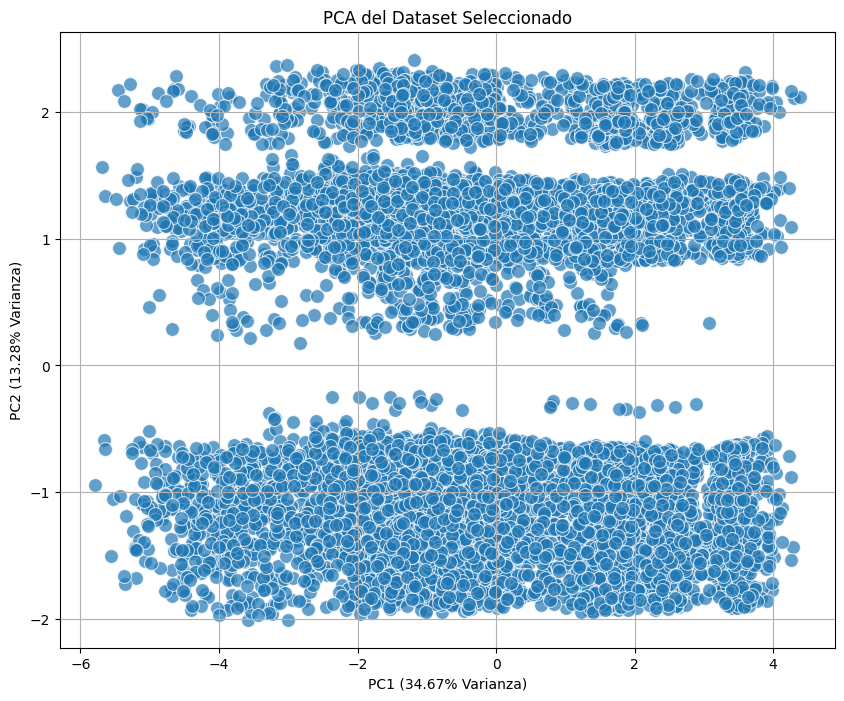

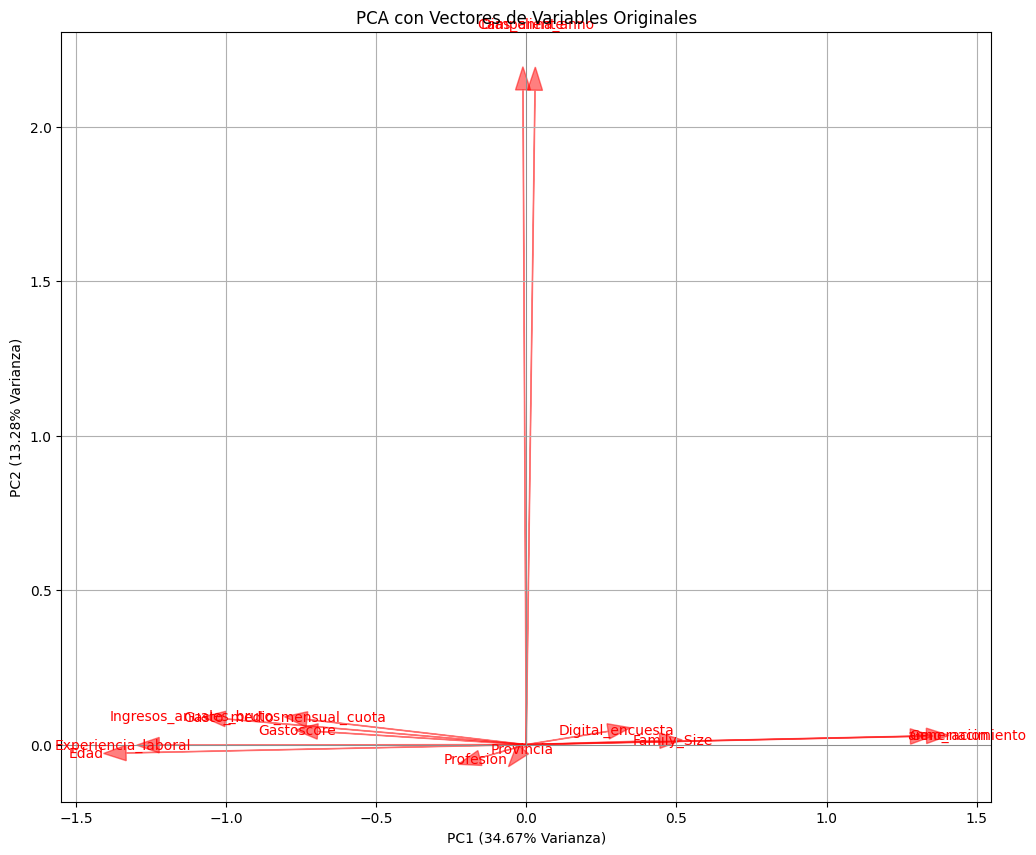


Cargas de las variables en las componentes principales:
                                PC1       PC2
Edad                      -0.444266 -0.009017
Profesion                 -0.051467 -0.014444
Experiencia_laboral       -0.407477 -0.000550
Gastoscore                -0.231512  0.014229
Family_Size                0.148185  0.004283
anno_nacimiento            0.444319  0.009434
Generacion                 0.426399  0.008797
Ingresos_anuales_brutos   -0.333866  0.027746
Provincia                 -0.003824 -0.004605
Digital_encuesta           0.090956  0.014341
Gasto_medio_mensual_cuota -0.243493  0.027232
Dias_cliente              -0.003596  0.706434
Campanna_anno              0.009710  0.706071


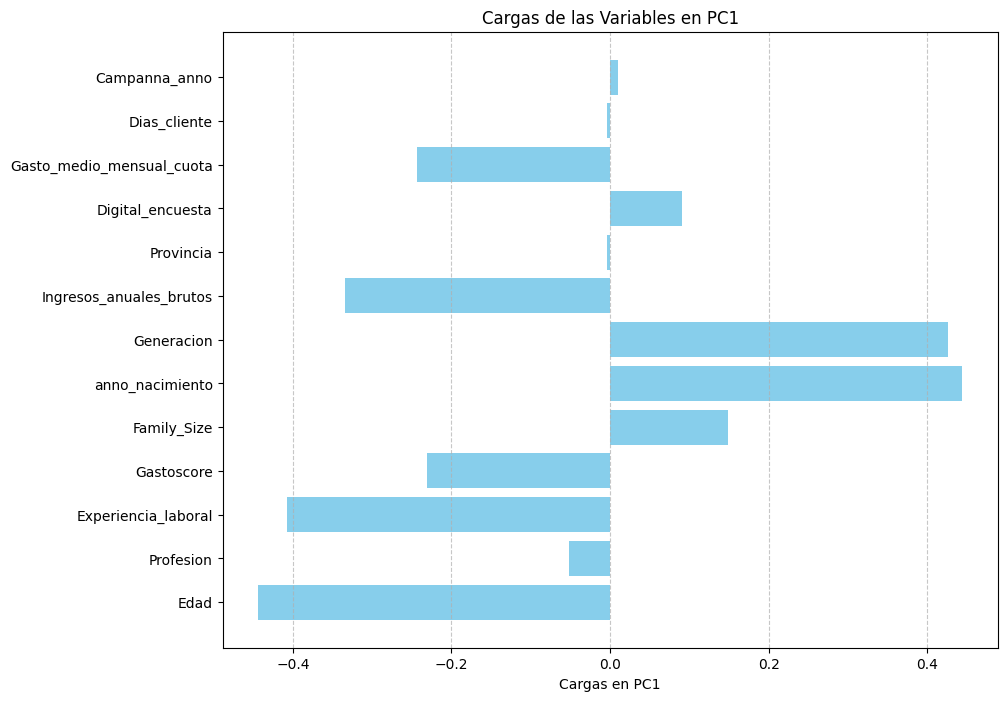

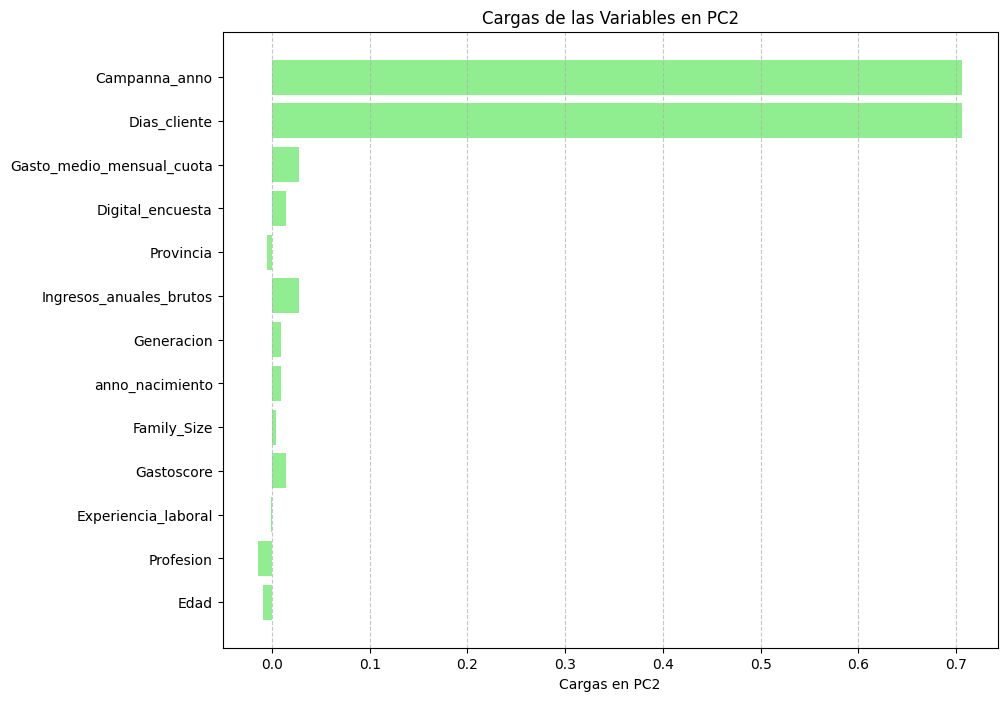

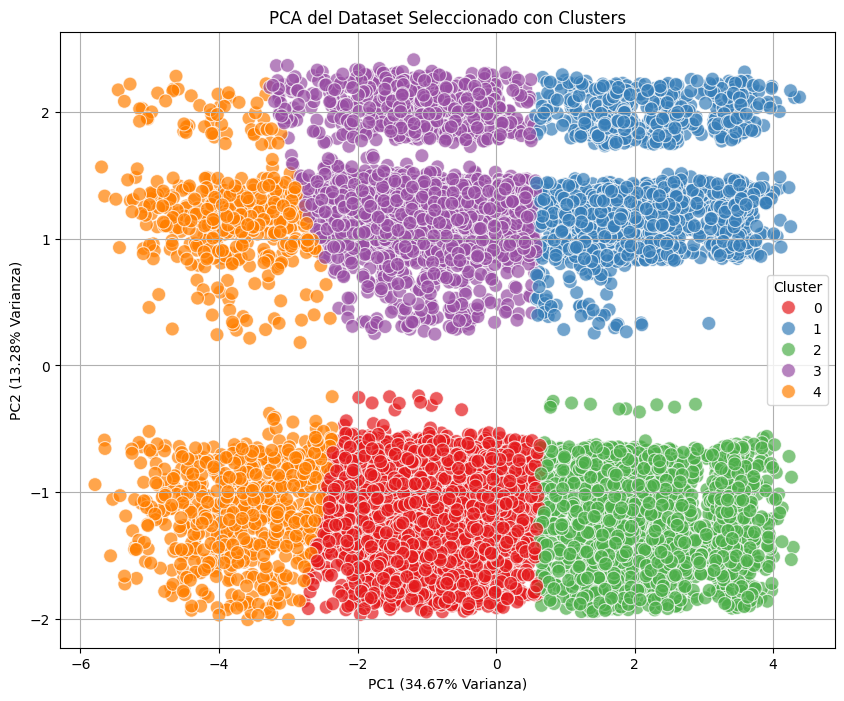

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Identificar variables numéricas
numerical_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()

# Identificar variables binarias y continuas
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    unique_values = df_selected[col].dropna().unique()
    if sorted(unique_values) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

# Excluir 'ID' si está presente en las continuas
if 'ID' in continuous_cols:
    continuous_cols.remove('ID')

# Verificar las columnas seleccionadas para PCA
print("\nVariables continuas seleccionadas para PCA:", continuous_cols)

# Seleccionar solo variables numéricas continuas
df_continuous = df_selected[continuous_cols]

# Manejo de valores faltantes
df_cleaned = df_continuous.dropna()

# Verificar si df_cleaned está vacío antes de continuar
if df_cleaned.empty:
    raise ValueError("❌ Error: No hay suficientes datos después de eliminar valores faltantes. Prueba imputar valores en lugar de eliminarlos.")

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)
print("\nDatos estandarizados:")
print(df_scaled.head())

# Aplicar PCA
n_components = 2  # Puedes ajustar este número según necesidades
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")

# Visualización: Scatter Plot
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA del Dataset Seleccionado')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

# Visualización: Biplot
cargas = pca.components_.T
escalamiento = 3  # Ajusta este valor según los datos
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12,10))

for i, var in enumerate(continuous_cols):
    plt.arrow(0, 0, cargas_scaled[i,0], cargas_scaled[i,1], 
              color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i,0]*1.1, cargas_scaled[i,1]*1.1, 
             var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

# 📌 Definir cargas_df antes de los gráficos
cargas_df = pd.DataFrame(cargas, index=continuous_cols, columns=['PC1', 'PC2'])
print("\nCargas de las variables en las componentes principales:")
print(cargas_df)

# 📊 Gráfico de Cargas para PC1
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC1'], color='skyblue')
plt.xlabel('Cargas en PC1')
plt.title('Cargas de las Variables en PC1')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Gráfico de Cargas para PC2
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC2'], color='lightgreen')
plt.xlabel('Cargas en PC2')
plt.title('Cargas de las Variables en PC2')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Clustering con K-Means sobre PCA
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame
pca_df['Cluster'] = clusters

# 📊 Visualizar PCA con Clusters
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA del Dataset Seleccionado con Clusters')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

### Cálculo nº clusters

#### Calcular la inercia para diferentes valores de k

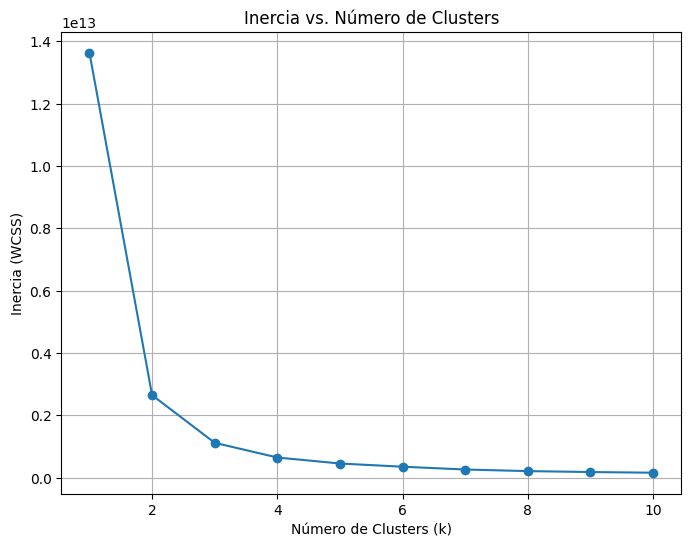

In [365]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Definir los rangos de k que vamos a probar (por ejemplo, de 1 a 10)
k_values = range(1, 11)
inercia = []

# Calcular inercia para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)  # Asegúrate de pasar solo las columnas numéricas
    inercia.append(kmeans.inertia_)

# Visualizar la inercia frente al número de clusters
plt.figure(figsize=(8, 6))
plt.plot(k_values, inercia, marker='o')
plt.title('Inercia vs. Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.grid(True)
plt.show()


## PCA y K-Means: Final

### Flags

In [366]:
# Flags para activar o desactivar columnas específicas
flags = {
    "ID": False,
    "Genero": True,
    "Casado": True,
    "Edad": False,
    "Graduado": True,
    "Profesion": True,
    "Experiencia_laboral": False,
    "Gastoscore": False,
    "Family_Size": False,
    "anno_nacimiento": True,
    "Generacion": False,
    "Ingresos_anuales_brutos": True,
    "Provincia": False,
    "Digital_encuesta": False,
    "Gasto_medio_mensual_cuota": True,
    "Abandono": True,
    "Dias_cliente": True,
    "Campanna_anno": False,
    "Region": True
}

# Filtrar columnas basadas en las flags activas
selected_columns = [col for col, flag in flags.items() if flag]

# Seleccionar las columnas del DataFrame que corresponden a las flags activas
df_selected = df[selected_columns]

#### Opción 2

In [367]:
# # Flags para activar o desactivar columnas específicas
# flags = {
#     "ID": False,
#     "Genero": True,
#     "Casado": True,
#     "Edad": False,
#     "Graduado": True,
#     "Profesion": True,
#     "Experiencia_laboral": True,
#     "Gastoscore": False,
#     "Family_Size": False,
#     "anno_nacimiento": True,
#     "Generacion": False,
#     "Ingresos_anuales_brutos": True,
#     "Provincia": False,
#     "Digital_encuesta": False,
#     "Gasto_medio_mensual_cuota": True,
#     "Abandono": True,
#     "Dias_cliente": True,
#     "Campanna_anno": False,
#     "Region": True
# }

# # Filtrar columnas basadas en las flags activas
# selected_columns = [col for col, flag in flags.items() if flag]

# # Seleccionar las columnas del DataFrame que corresponden a las flags activas
# df_selected = df[selected_columns]

### Aplicación


Variables continuas seleccionadas para PCA: ['Profesion', 'anno_nacimiento', 'Ingresos_anuales_brutos', 'Gasto_medio_mensual_cuota', 'Dias_cliente', 'Region']

Datos estandarizados:
   Profesion  anno_nacimiento  Ingresos_anuales_brutos  \
0   0.268026        -1.034957                 1.052800   
1   0.623398        -0.872187                 1.231385   
2  -1.153465        -0.926444                -0.545951   
3  -0.087347         0.809766                -0.888343   
4   1.334144        -0.221108                -0.741176   

   Gasto_medio_mensual_cuota  Dias_cliente    Region  
0                   1.210732     -0.692072 -1.344205  
1                   0.164441      0.416520 -0.788971  
2                  -0.533086      0.732300 -1.344205  
3                  -0.533086      1.652767  0.321497  
4                  -0.533086     -0.860041 -0.788971  
PC1: 33.24%
PC2: 17.58%


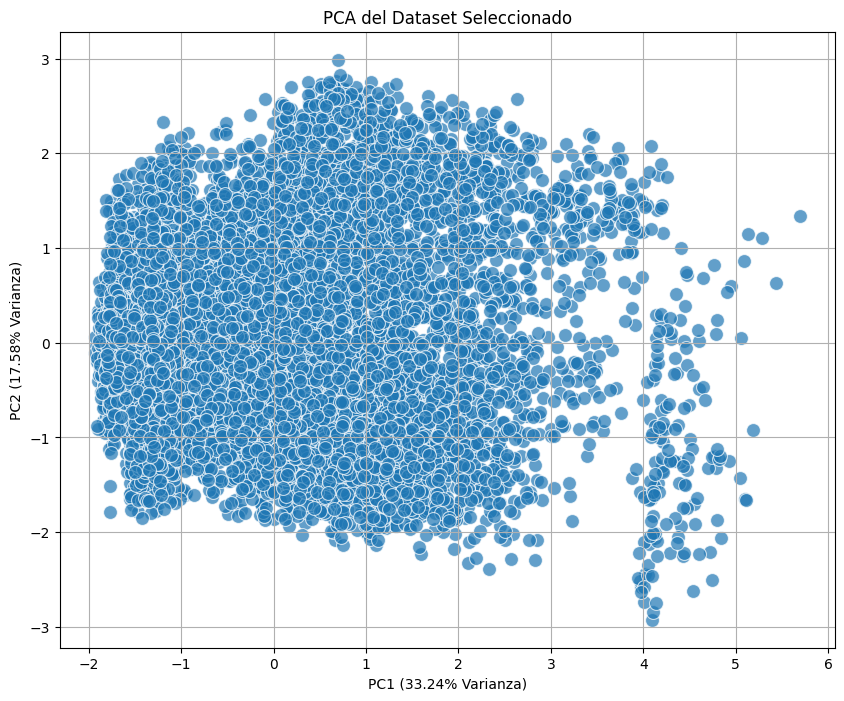

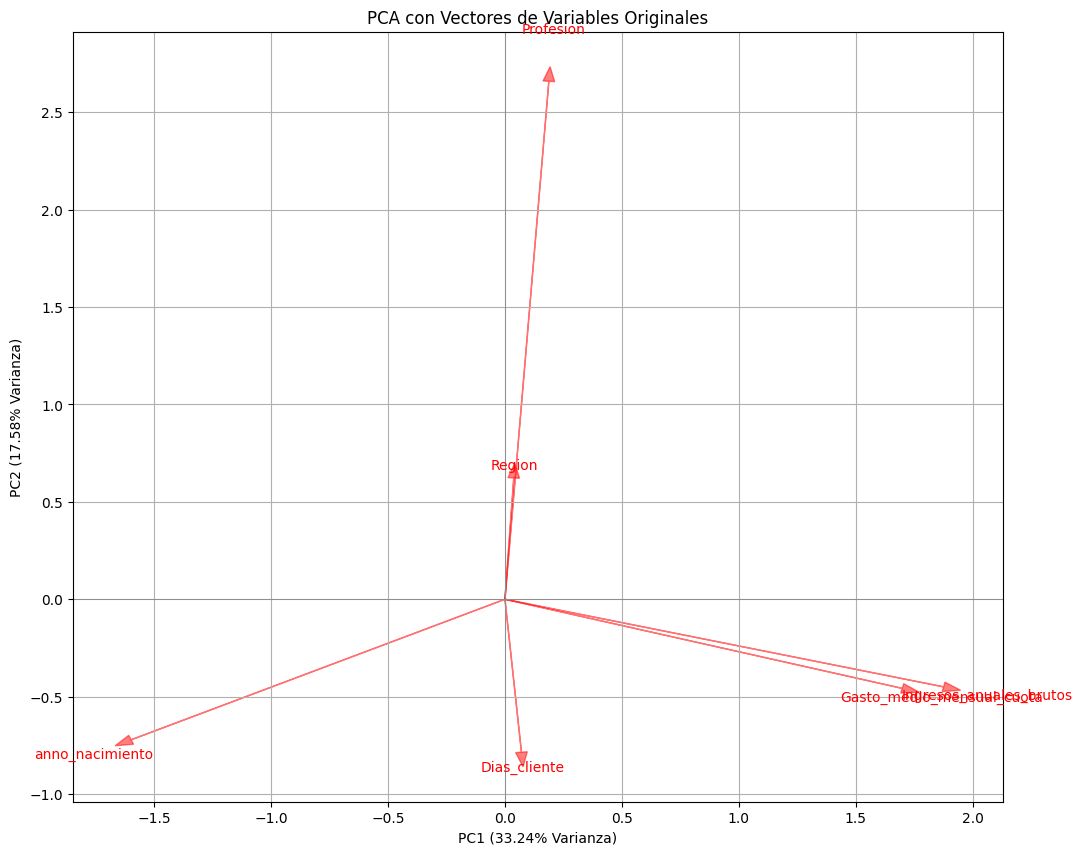


Cargas de las variables en las componentes principales:
                                PC1       PC2
Profesion                  0.062564  0.886074
anno_nacimiento           -0.532818 -0.240326
Ingresos_anuales_brutos    0.625203 -0.149810
Gasto_medio_mensual_cuota  0.566217 -0.152384
Dias_cliente               0.023509 -0.261518
Region                     0.012556  0.207510


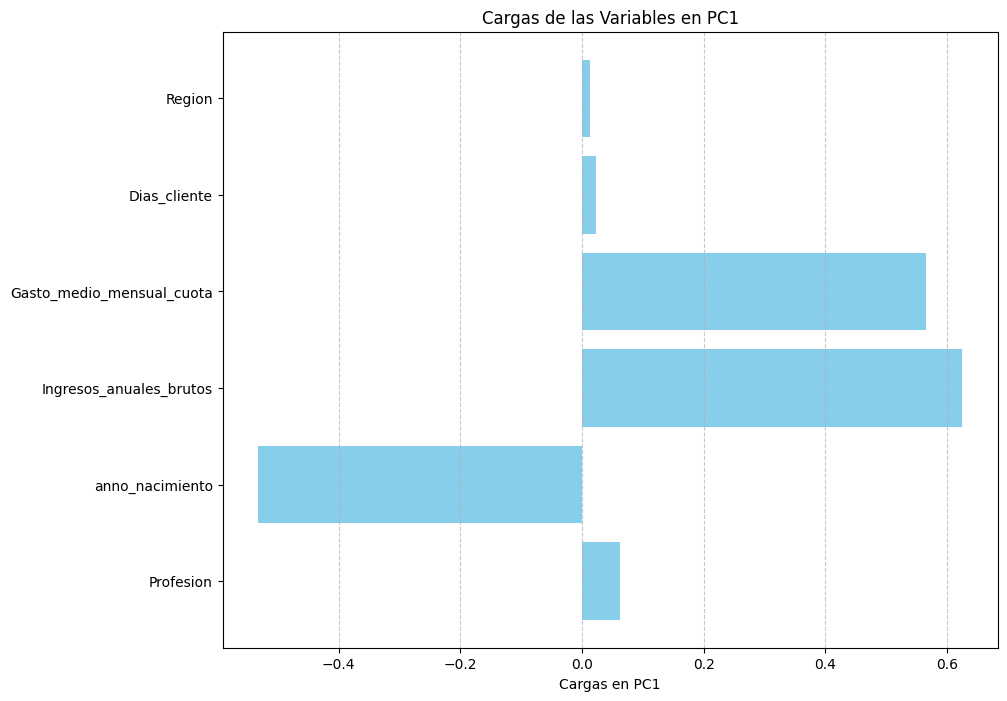

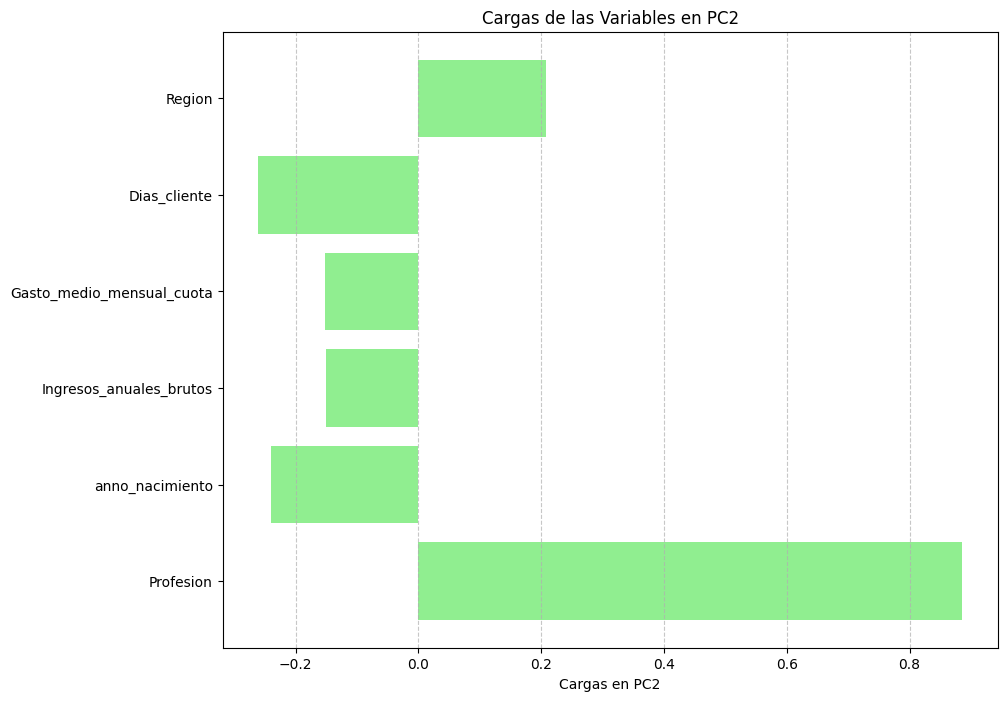

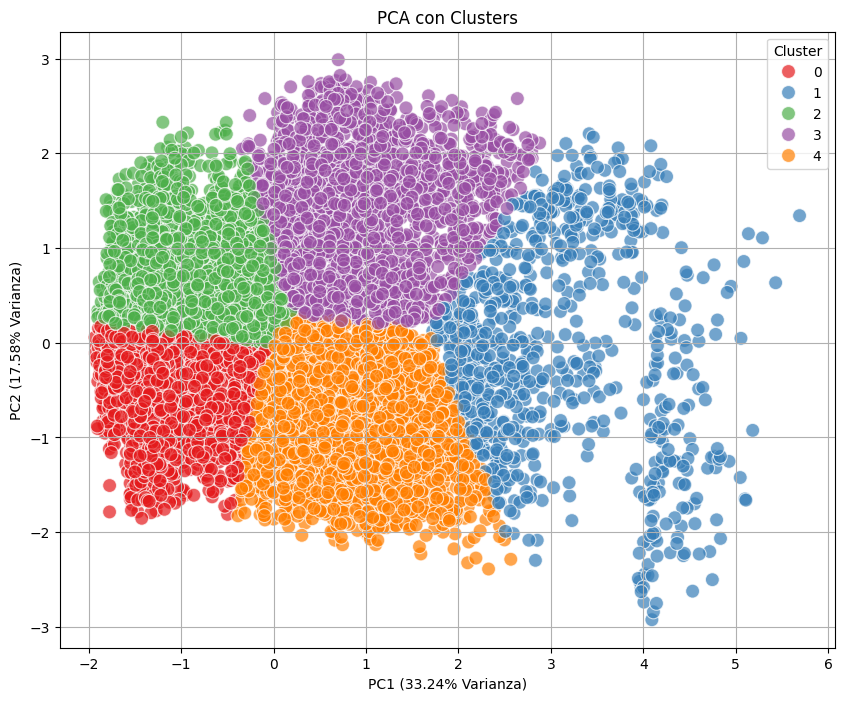

In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Identificar variables numéricas
numerical_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()

# Identificar variables binarias y continuas
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    unique_values = df_selected[col].dropna().unique()
    if sorted(unique_values) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

# Excluir 'ID' si está presente en las continuas
if 'ID' in continuous_cols:
    continuous_cols.remove('ID')

# Verificar las columnas seleccionadas para PCA
print("\nVariables continuas seleccionadas para PCA:", continuous_cols)

# Seleccionar solo variables numéricas continuas
df_continuous = df_selected[continuous_cols]

# Manejo de valores faltantes
df_cleaned = df_continuous.dropna()

# Verificar si df_cleaned está vacío antes de continuar
if df_cleaned.empty:
    raise ValueError("❌ Error: No hay suficientes datos después de eliminar valores faltantes. Prueba imputar valores en lugar de eliminarlos.")

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)
print("\nDatos estandarizados:")
print(df_scaled.head())

# Aplicar PCA
n_components = 2  # Puedes ajustar este número según necesidades
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")

# Visualización: Scatter Plot
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA del Dataset Seleccionado')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

# Visualización: Biplot
cargas = pca.components_.T
escalamiento = 3  # Ajusta este valor según los datos
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12,10))

for i, var in enumerate(continuous_cols):
    plt.arrow(0, 0, cargas_scaled[i,0], cargas_scaled[i,1], 
              color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i,0]*1.1, cargas_scaled[i,1]*1.1, 
             var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

# 📌 Definir cargas_df antes de los gráficos
cargas_df = pd.DataFrame(cargas, index=continuous_cols, columns=['PC1', 'PC2'])
print("\nCargas de las variables en las componentes principales:")
print(cargas_df)

# 📊 Gráfico de Cargas para PC1
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC1'], color='skyblue')
plt.xlabel('Cargas en PC1')
plt.title('Cargas de las Variables en PC1')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Gráfico de Cargas para PC2
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC2'], color='lightgreen')
plt.xlabel('Cargas en PC2')
plt.title('Cargas de las Variables en PC2')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Clustering con K-Means sobre PCA
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame de PCA (no al original)
pca_df['Cluster'] = clusters

# Crear un DataFrame separado para los resultados del clustering
df_resultados = df_selected.copy()
df_resultados['Cluster'] = clusters 

# 📊 Visualizar PCA con Clusters (usando pca_df)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA con Clusters')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

In [369]:
import pandas as pd
import numpy as np

# --- Step 1: Load your processed DataFrame ---
# For example, if loaded from CSV:
# df = pd.read_csv("df(10).csv")

# Ensure the DataFrame has a "Cluster" column. If not, raise an error.
if "Cluster" not in df_resultados.columns:
    raise ValueError("The df does not have a 'Cluster' column. Please run your clustering algorithm first.")

# --- Step 2: Convert Boolean columns to binary (integers) ---
bool_cols = df_resultados.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    print("Converting boolean columns to integers:", bool_cols)
    df_resultados[bool_cols] = df_resultados[bool_cols].astype(int)
else:
    print("No boolean columns detected.")

# --- Step 3: Identify all numeric columns for evaluation ---
# This should now include the converted dummy columns.
num_cols = df_resultados.select_dtypes(include=[np.number]).columns.tolist()
if "Cluster" in num_cols:
    num_cols.remove("Cluster")  # Exclude the Cluster column

# --- Step 4: Compute the overall mean for each numeric variable ---
overall_means = df_resultados[num_cols].mean()

# --- Step 5: Compute the mean for each numeric variable within each cluster ---
cluster_means = df_resultados.groupby("Cluster")[num_cols].mean()

# --- Step 6: Compute the ratio of cluster mean to overall mean for each variable ---
ratio_df = cluster_means.divide(overall_means, axis=1)

# --- Step 7: Transpose the table so that rows are variables and columns are clusters ---
ratio_df = ratio_df.transpose()
ratio_df.columns = [f"Cluster {c}" for c in ratio_df.columns]

# --- Optional: Round the values for readability ---
ratio_df = ratio_df.round(2)

print("Relative Mean Ratios (Cluster Mean / Overall Mean) for All Numeric Variables:")
print(ratio_df)

# Optionally, save this table to CSV:
# ratio_df.to_csv("cluster_relative_ratios.csv", index=True)

No boolean columns detected.
Relative Mean Ratios (Cluster Mean / Overall Mean) for All Numeric Variables:
                           Cluster 0  Cluster 1  Cluster 2  Cluster 3  \
Genero                          0.99       1.08       0.98       1.04   
Casado                          0.62       1.50       0.66       1.40   
Graduado                        0.83       0.57       0.75       1.17   
Profesion                       0.53       1.31       1.57       2.10   
anno_nacimiento                 1.01       0.99       1.01       0.99   
Ingresos_anuales_brutos         0.48       1.97       0.52       1.35   
Gasto_medio_mensual_cuota       0.67       2.72       0.68       1.00   
Abandono                        0.94       1.01       1.04       1.12   
Dias_cliente                    1.08       1.01       0.86       0.92   
Region                          0.89       1.04       1.15       1.12   

                           Cluster 4  
Genero                          0.98  
Casado     

### Guardar en excels

#### 1. Archivo PCA con Clusters (Visualización)

In [370]:
# !pip install openpyxl

In [371]:
import pandas as pd
import numpy as np  

# Crear DataFrame con las componentes PCA y los clusters
pca_clusters_df = pca_df.copy()

# Guardar en Excel (solo datos de PCA + clusters)
pca_clusters_df.to_excel("pca_clusters.xlsx", index=False)

#### 2. Archivo Dataset Original con Clusters


In [377]:
# 1. Guardar PCA con Clusters (para el gráfico)
pca_clusters_df = pca_df.copy()
pca_clusters_df.to_excel("pca_clusters.xlsx", index=False, engine='openpyxl')

# 2. Guardar DF Original con Clusters (alineando índices)
# Crear columna 'Cluster' en df_sin_na con NaN por defecto
df_sin_na["Cluster"] = np.nan

# Asignar clusters solo a las filas procesadas (que pasaron por dropna)
df_sin_na.loc[df_cleaned.index, "Cluster"] = clusters

# Guardar en Excel
df_sin_na.to_excel("datos_final.xlsx", index=False, engine='openpyxl')

#### 3. Características de cada Cluster

In [380]:
import pandas as pd

# Crear los datos de los clusters
data = {
    "Cluster": [0, 1, 2, 3, 4],
    "Nombre": [
        "Joven Funcionario Desconectado",
        "Patriarca Conservador de Alto Ingreso",
        "Millennial Básico Desvinculado",
        "Veterano Académico Estable",
        "Creativo Digital de Renta Alta"
    ],
    "Descripcion": [
        "Hombres jóvenes, funcionarios, con bajo nivel de digitalización y bajo gasto mensual. Perfil poco conectado digitalmente.",
        "Hombres mayores, casados, sin estudios superiores, con altísima experiencia laboral, ingresos elevados y hábitos tradicionales.",
        "Adultos jóvenes sin estudios superiores, con ingresos bajos y escaso gasto. Perfil desconectado digitalmente y con estilo de vida austero.",
        "Hombres mayores con estudios superiores, casados, con amplia experiencia y situación económica estable. Perfil tradicional pero con educación avanzada.",
        "Hombres de mediana edad, artistas con alto poder adquisitivo, nivel digital decente y gastos mensuales considerables."
    ],
    "Edad_media": [35, 67, 36, 67, 55],
    "Genero": ["M", "M", "M", "M", "M"],
    "Casado": ["No", "Sí", "No", "Sí", "Sí"],
    "Graduado": ["Sí", "No", "No", "Sí", "Sí"],
    "Profesion": ["Funcionario", "Servicios", "Otros", "Servicios", "Artista"],
    "Experiencia_laboral": ["<10 años", "+20 años", "10–20 años", "+20 años", "+20 años"],
    "Generacion": ["Millennials", "Generación X", "Millennials", "Generación X", "Generación X"],
    "Ingresos_anuales_brutos": [26821, 110635, 29183, 75825, 84436],
    "Gasto_medio_mensual_cuota": [31, 123, 31, 45, 53],
    "Digital_encuesta": [1899, 1446, 1668, 1365, 1394],
    "Region": ["Norte", "Norte", "Norte", "Norte", "Norte"]
}

# Crear el DataFrame
cluster_df = pd.DataFrame(data)

# Guardar en un archivo Excel para importar en Power BI
output_path = "cluster_perfiles_powerbi.xlsx"
cluster_df.to_excel(output_path, index=False)

output_path


'cluster_perfiles_powerbi.xlsx'

### Detalles de cada Cluster


Características de cada cluster:
        Genero Casado  Edad Graduado    Profesion Experiencia_laboral  \
Cluster                                                                 
0.0          M     No  35.0       Si  Funcionario            <10annos   
1.0          M     Si  67.0       No    Servicios            +20annos   
2.0          M     No  36.0       No        Otros          10-20annos   
3.0          M     Si  67.0       Si    Servicios            +20annos   
4.0          M     Si  55.0       Si      Artista            +20annos   

        Gastoscore  Family_Size  anno_nacimiento    Generacion  \
Cluster                                                          
0.0           Bajo          3.0           1989.0   Millennials   
1.0           Bajo          2.0           1957.0  Generacion X   
2.0           Bajo          3.0           1988.0   Millennials   
3.0           Bajo          2.0           1957.0  Generacion X   
4.0           Bajo          2.0           1969.0  Generaci

<Figure size 1200x800 with 0 Axes>

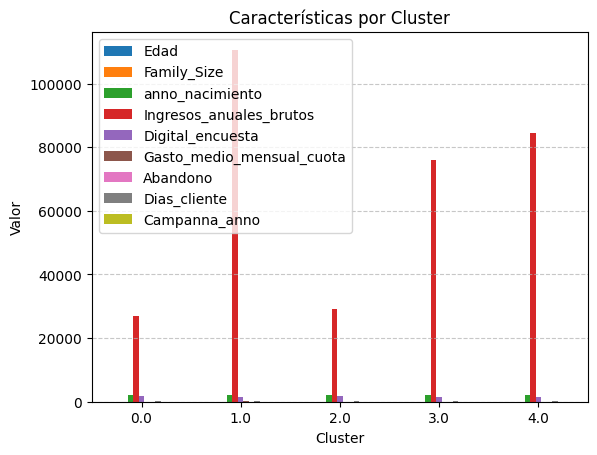

In [378]:
# Definir función personalizada para aplicar moda a categóricas y redondear numéricas
def custom_agg(x):
    if x.dtype == 'O':  # Si es categórica (object)
        return x.mode()[0] if not x.mode().empty else 'Sin moda'
    else:  # Si es numérica
        return round(x.mean(), 0)  # Redondear a 0 decimales

# Aplicar agregación
cluster_mode = df_sin_na.groupby('Cluster').agg(custom_agg)

print("\nCaracterísticas de cada cluster:")
print(cluster_mode)

# Visualización (sin decimales en el eje Y)
plt.figure(figsize=(12,8))
cluster_mode.plot(kind='bar')
plt.title('Características por Cluster')
plt.ylabel('Valor')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))  # Sin decimales
plt.show()

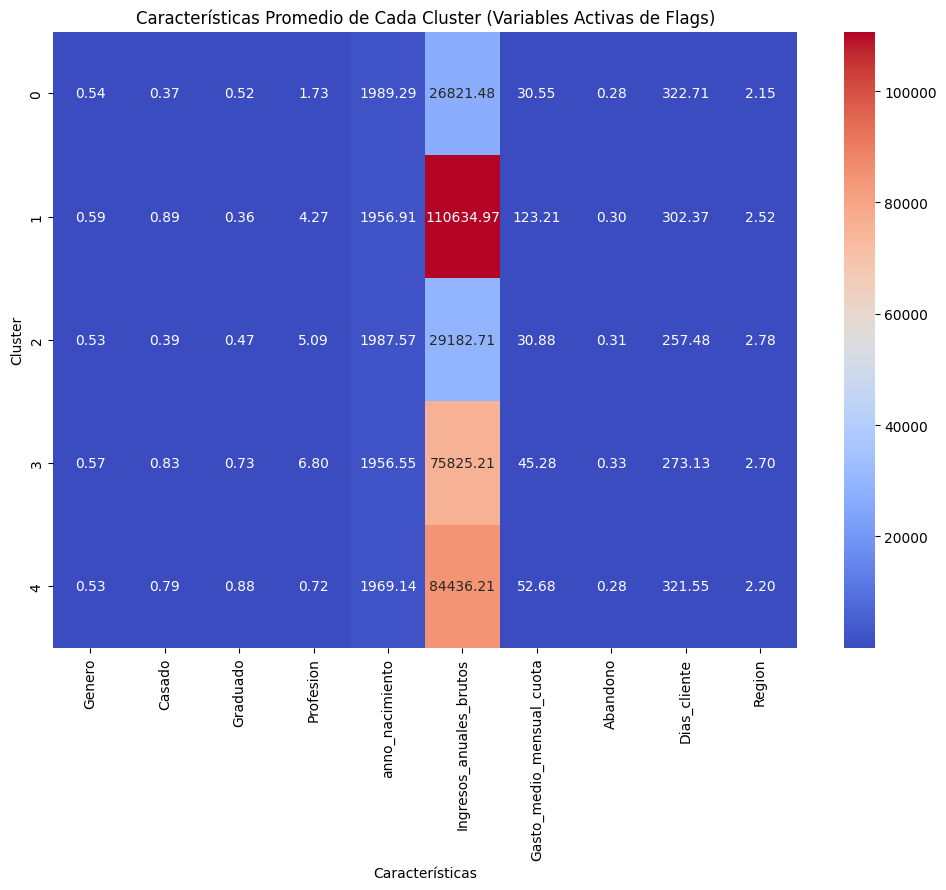

In [376]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar las columnas que están activadas en 'flags'
columns_to_include = [col for col, flag in flags.items() if flag]

# Asegurarse de que estas columnas estén en el DataFrame
df_flags = df_resultados[columns_to_include + ['Cluster']]

# Calcular la media de las variables para cada cluster
cluster_summary_flags = df_flags.groupby('Cluster').mean()

# Visualizar las características de cada cluster utilizando un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary_flags, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Características Promedio de Cada Cluster (Variables Activas de Flags)')
plt.xlabel('Características')
plt.ylabel('Cluster')
plt.show()

## Gráficos

C:\Users\aleja\AppData\Local\Temp\ipykernel_24532\377175926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={



Datos estandarizados:
   profesión  año nacimiento  ingresos anuales brutos  gasto medio mensual  \
0   0.268026       -1.034957                 1.052800             1.210732   
1   0.623398       -0.872187                 1.231385             0.164441   
2  -1.153465       -0.926444                -0.545951            -0.533086   
3  -0.087347        0.809766                -0.888343            -0.533086   
4   1.334144       -0.221108                -0.741176            -0.533086   

   dias siendo cliente    región  
0            -0.692072 -1.344205  
1             0.416520 -0.788971  
2             0.732300 -1.344205  
3             1.652767  0.321497  
4            -0.860041 -0.788971  
PC1: 33.24%
PC2: 17.58%


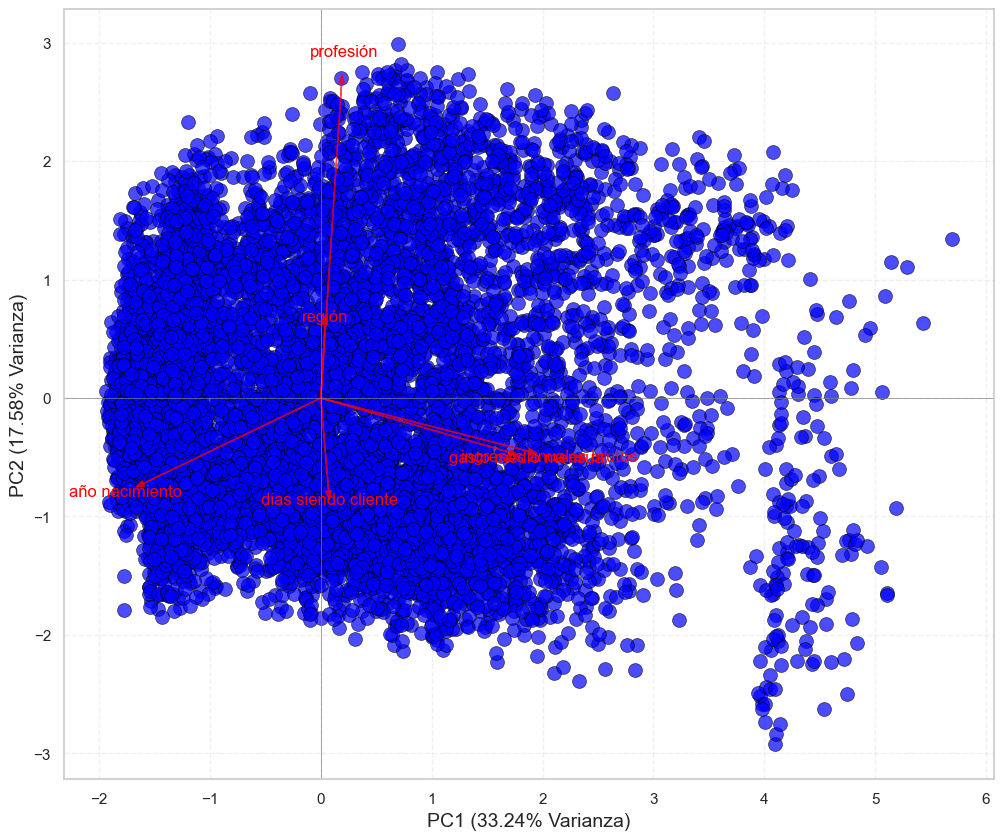


Cargas de las variables en las componentes principales:
                              PC1       PC2
profesión                0.062564  0.886074
año nacimiento          -0.532818 -0.240326
ingresos anuales brutos  0.625203 -0.149810
gasto medio mensual      0.566217 -0.152384
dias siendo cliente      0.023509 -0.261518
región                   0.012556  0.207510


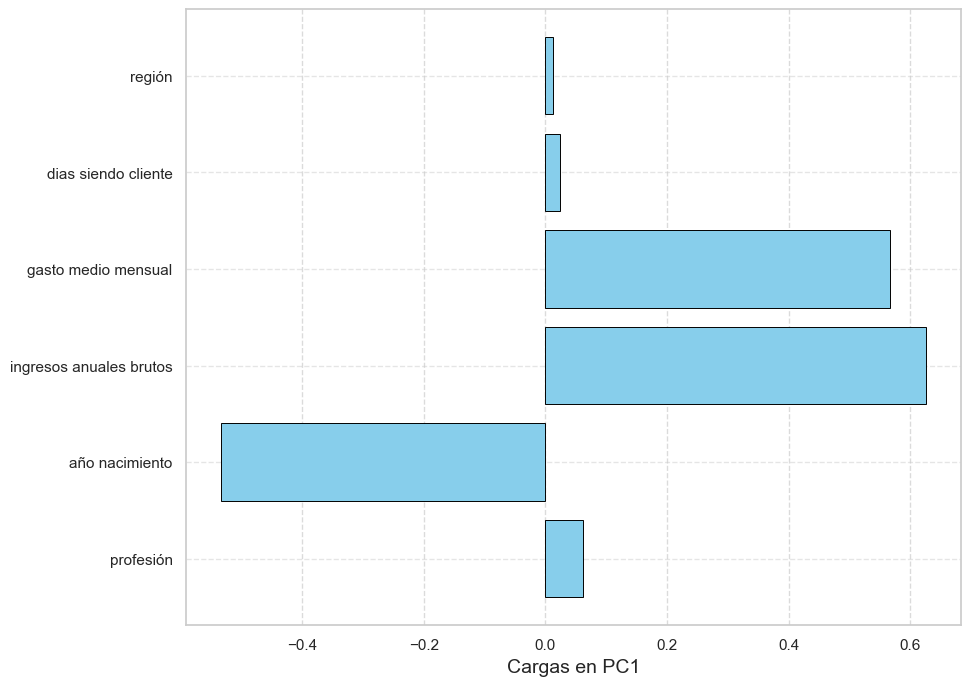

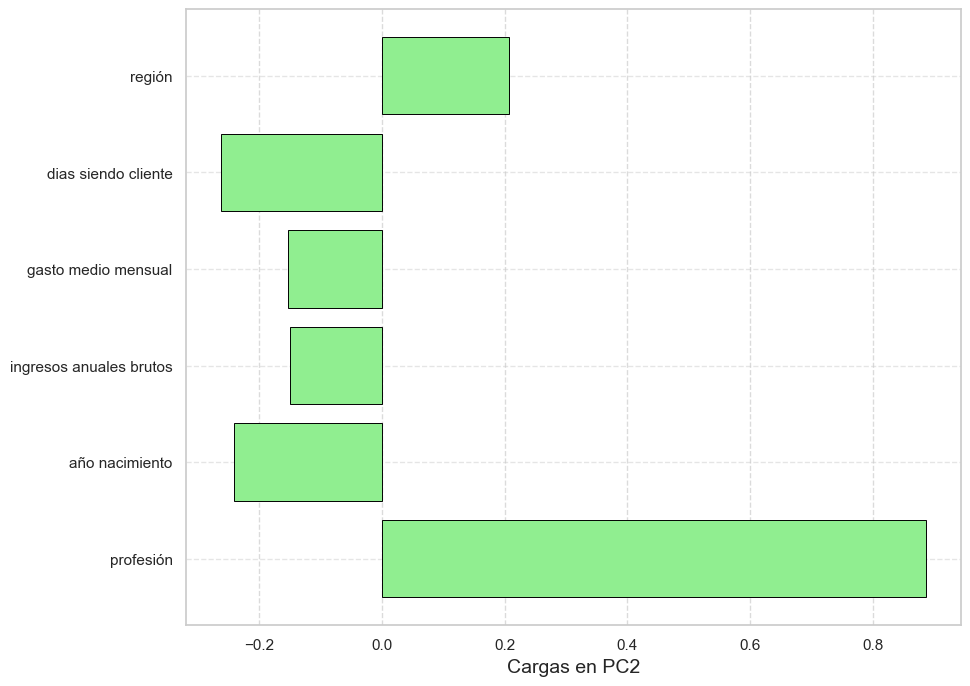

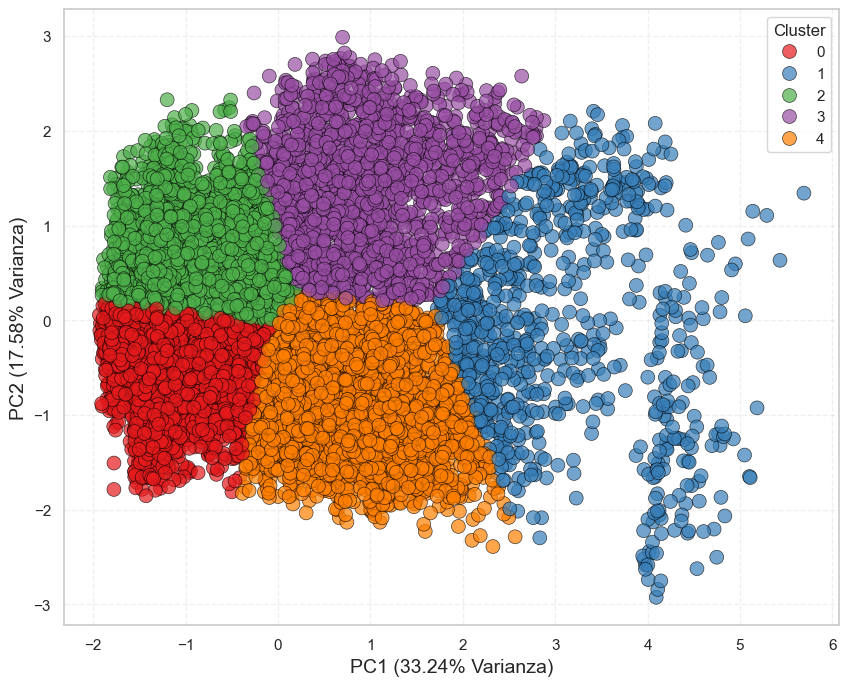

In [ ]:
# Renombrar las columnas
df_selected.rename(columns={
    'Profesion': 'profesión',
    'anno_nacimiento': 'año nacimiento',
    'Ingresos_anuales_brutos': 'ingresos anuales brutos',
    'Gasto_medio_mensual_cuota': 'gasto medio mensual',
    'Dias_cliente': 'días siendo cliente',
    'Region': 'región'
}, inplace=True)

# Rehacer todo el flujo de procesamiento después del renombrado de columnas

# Identificar variables numéricas
numerical_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()

# Identificar variables binarias y continuas
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    unique_values = df_selected[col].dropna().unique()
    if sorted(unique_values) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

# Excluir 'ID' si está presente en las continuas
if 'ID' in continuous_cols:
    continuous_cols.remove('ID')

# Seleccionar solo variables numéricas continuas
df_continuous = df_selected[continuous_cols]

# Manejo de valores faltantes
df_cleaned = df_continuous.dropna()

# Verificar si df_cleaned está vacío antes de continuar
if df_cleaned.empty:
    raise ValueError("❌ Error: No hay suficientes datos después de eliminar valores faltantes. Prueba imputar valores en lugar de eliminarlos.")

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)
print("\nDatos estandarizados:")
print(df_scaled.head())

# Aplicar PCA
n_components = 2  # Puedes ajustar este número según necesidades
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")

# Visualización combinada: Scatter Plot + Biplot
plt.figure(figsize=(12,10))

# Scatter plot de PCA
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7, color='blue', edgecolor='black', linewidth=0.5)

# Añadir vectores de carga (biplot)
cargas = pca.components_.T
escalamiento = 3  # Ajusta este valor según los datos
cargas_scaled = cargas * escalamiento
for i, var in enumerate(continuous_cols):
    plt.arrow(0, 0, cargas_scaled[i,0], cargas_scaled[i,1], 
              color='red', alpha=0.7, head_width=0.05)
    plt.text(cargas_scaled[i,0]*1.1, cargas_scaled[i,1]*1.1, 
             var, color='red', ha='center', va='center', fontsize=12)

# Configuración de los ejes
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)', fontsize=14)
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

# 📌 Definir cargas_df antes de los gráficos
cargas_df = pd.DataFrame(cargas, index=continuous_cols, columns=['PC1', 'PC2'])
print("\nCargas de las variables en las componentes principales:")
print(cargas_df)

# 📊 Gráfico de Cargas para PC1
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC1'], color='skyblue', edgecolor='black', linewidth=0.7)
plt.xlabel('Cargas en PC1', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Gráfico de Cargas para PC2
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC2'], color='lightgreen', edgecolor='black', linewidth=0.7)
plt.xlabel('Cargas en PC2', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Clustering con K-Means sobre PCA
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame de PCA (no al original)
pca_df['Cluster'] = clusters

# Crear un DataFrame separado para los resultados del clustering
df_resultados = df_selected.copy()
df_resultados['Cluster'] = clusters 

# 📊 Visualizar PCA con Clusters (usando pca_df)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)', fontsize=14)
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


C:\Users\aleja\AppData\Local\Temp\ipykernel_24532\2989691963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={



Datos estandarizados:
   profesión  año nacimiento  ingresos anuales brutos  gasto medio mensual  \
0   0.268026       -1.034957                 1.052800             1.210732   
1   0.623398       -0.872187                 1.231385             0.164441   
2  -1.153465       -0.926444                -0.545951            -0.533086   
3  -0.087347        0.809766                -0.888343            -0.533086   
4   1.334144       -0.221108                -0.741176            -0.533086   

   dias siendo cliente    región  
0            -0.692072 -1.344205  
1             0.416520 -0.788971  
2             0.732300 -1.344205  
3             1.652767  0.321497  
4            -0.860041 -0.788971  
PC1: 33.24%
PC2: 17.58%


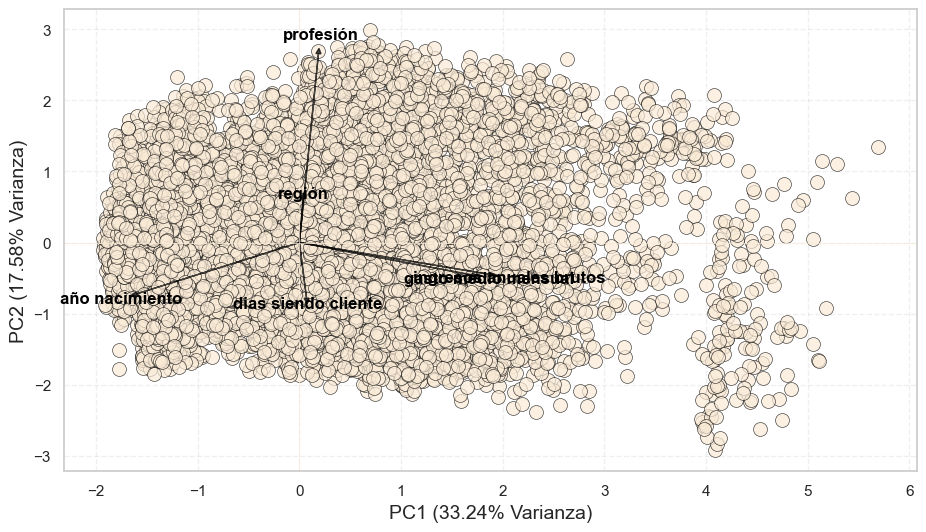


Cargas de las variables en las componentes principales:
                              PC1       PC2
profesión                0.062564  0.886074
año nacimiento          -0.532818 -0.240326
ingresos anuales brutos  0.625203 -0.149810
gasto medio mensual      0.566217 -0.152384
dias siendo cliente      0.023509 -0.261518
región                   0.012556  0.207510


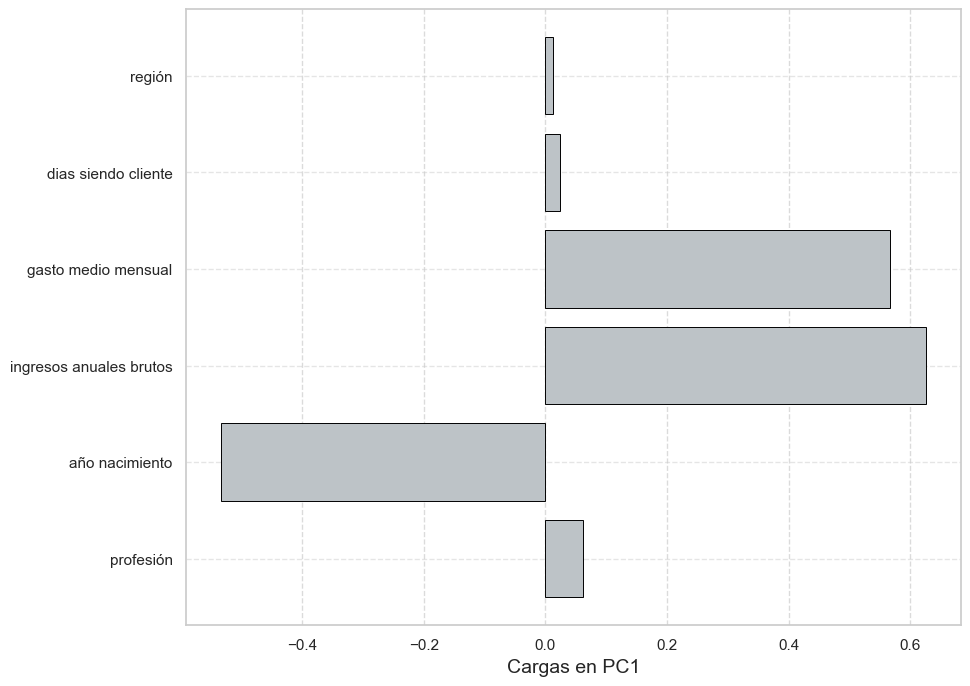

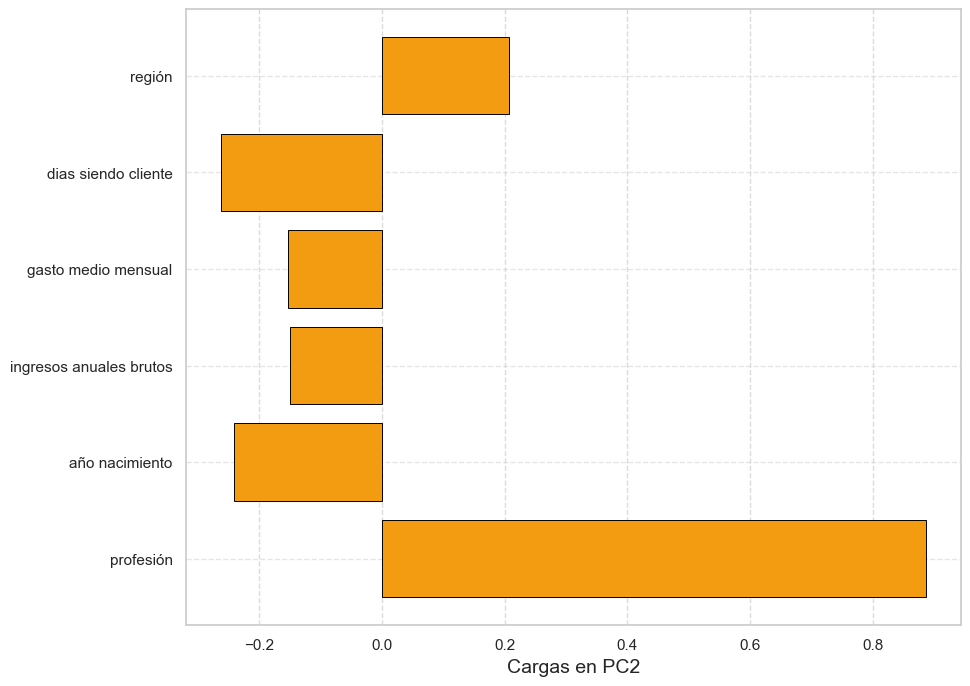

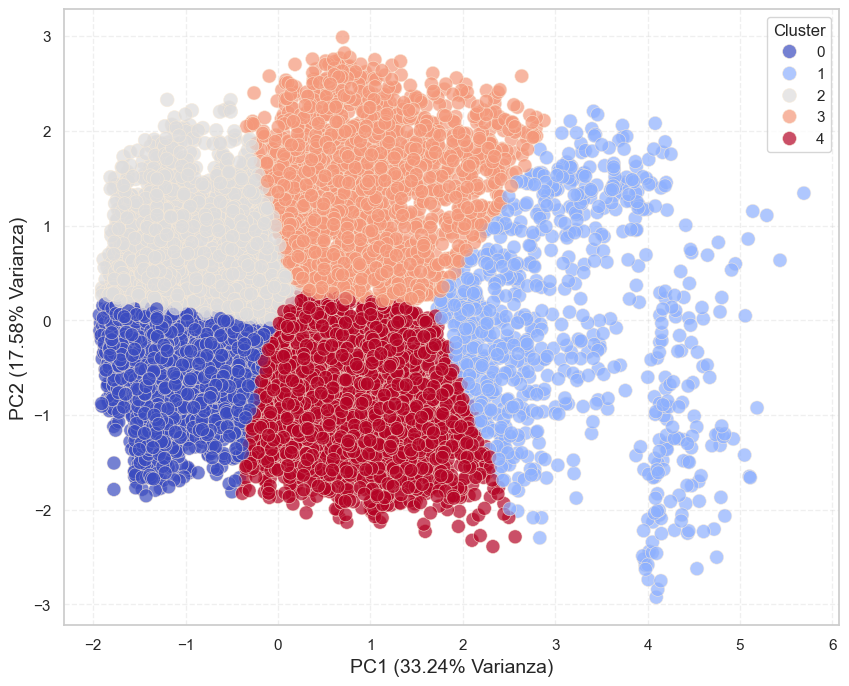

In [403]:
# Renombrar las columnas
df_selected.rename(columns={
    'Profesion': 'profesión',
    'anno_nacimiento': 'año nacimiento',
    'Ingresos_anuales_brutos': 'ingresos anuales brutos',
    'Gasto_medio_mensual_cuota': 'gasto medio mensual',
    'Dias_cliente': 'días siendo cliente',
    'Region': 'región'
}, inplace=True)

# Rehacer todo el flujo de procesamiento después del renombrado de columnas

# Identificar variables numéricas
numerical_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()

# Identificar variables binarias y continuas
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    unique_values = df_selected[col].dropna().unique()
    if sorted(unique_values) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

# Excluir 'ID' si está presente en las continuas
if 'ID' in continuous_cols:
    continuous_cols.remove('ID')

# Seleccionar solo variables numéricas continuas
df_continuous = df_selected[continuous_cols]

# Manejo de valores faltantes
df_cleaned = df_continuous.dropna()

# Verificar si df_cleaned está vacío antes de continuar
if df_cleaned.empty:
    raise ValueError("❌ Error: No hay suficientes datos después de eliminar valores faltantes. Prueba imputar valores en lugar de eliminarlos.")

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)
print("\nDatos estandarizados:")
print(df_scaled.head())

# Aplicar PCA
n_components = 2  # Puedes ajustar este número según necesidades
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")

# Visualización combinada: Scatter Plot + Biplot
plt.figure(figsize=(11,6))

# Scatter plot de PCA con colores más neutrales
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7, color='#FAEBD7', edgecolor='black', linewidth=0.5)

# Añadir vectores de carga (biplot)
cargas = pca.components_.T
escalamiento = 3  # Ajusta este valor según los datos
cargas_scaled = cargas * escalamiento
for i, var in enumerate(continuous_cols):
    plt.arrow(0, 0, cargas_scaled[i,0], cargas_scaled[i,1], 
              color='black', alpha=0.7, head_width=0.05)
    plt.text(cargas_scaled[i,0]*1.1, cargas_scaled[i,1]*1.1, 
             var, color='black', ha='center', va='center', fontsize=12, fontweight='bold')

# Configuración de los ejes
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)', fontsize=14)
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axhline(0, color='#FAEBD7', linewidth=0.5)
plt.axvline(0, color='#FAEBD7', linewidth=0.5)
plt.show()

# 📌 Definir cargas_df antes de los gráficos
cargas_df = pd.DataFrame(cargas, index=continuous_cols, columns=['PC1', 'PC2'])
print("\nCargas de las variables en las componentes principales:")
print(cargas_df)

# 📊 Gráfico de Cargas para PC1
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC1'], color='#BDC3C7', edgecolor='black', linewidth=0.7)
plt.xlabel('Cargas en PC1', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Gráfico de Cargas para PC2
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC2'], color='#F39C12', edgecolor='black', linewidth=0.7)
plt.xlabel('Cargas en PC2', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 📊 Clustering con K-Means sobre PCA
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame de PCA (no al original)
pca_df['Cluster'] = clusters

# Crear un DataFrame separado para los resultados del clustering
df_resultados = df_selected.copy()
df_resultados['Cluster'] = clusters 

# 📊 Visualizar PCA con Clusters (usando pca_df)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='coolwarm', s=100, alpha=0.7, edgecolor='#FAEBD7', linewidth=0.5)
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)', fontsize=14)
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


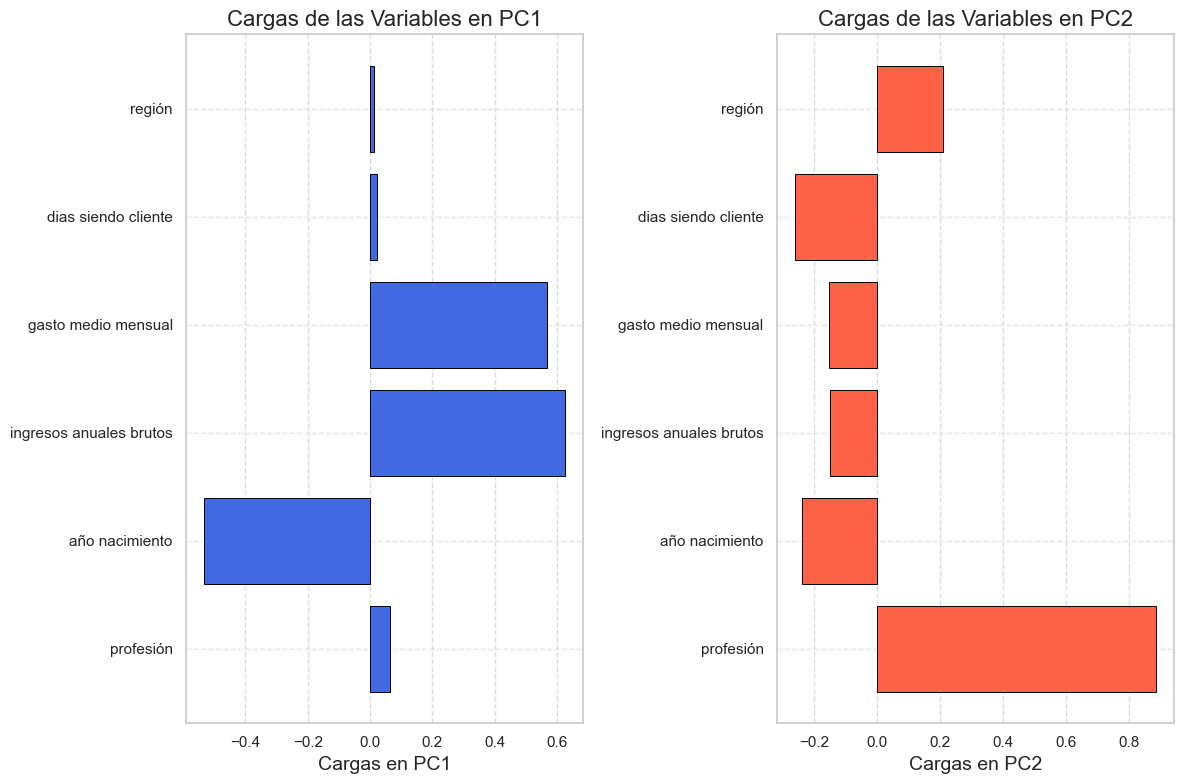

In [405]:
# 📊 Gráfico combinado de Cargas para PC1 y PC2
plt.figure(figsize=(12,8))

# Primer subgráfico: Cargas en PC1
plt.subplot(1, 2, 1)  # (filas, columnas, índice del gráfico)
plt.barh(cargas_df.index, cargas_df['PC1'], color='royalblue', edgecolor='black', linewidth=0.7)
plt.xlabel('Cargas en PC1', fontsize=14)
plt.title('Cargas de las Variables en PC1', fontsize=16)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Segundo subgráfico: Cargas en PC2
plt.subplot(1, 2, 2)
plt.barh(cargas_df.index, cargas_df['PC2'], color='tomato', edgecolor='black', linewidth=0.7)
plt.xlabel('Cargas en PC2', fontsize=14)
plt.title('Cargas de las Variables en PC2', fontsize=16)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar el gráfico combinado
plt.show()


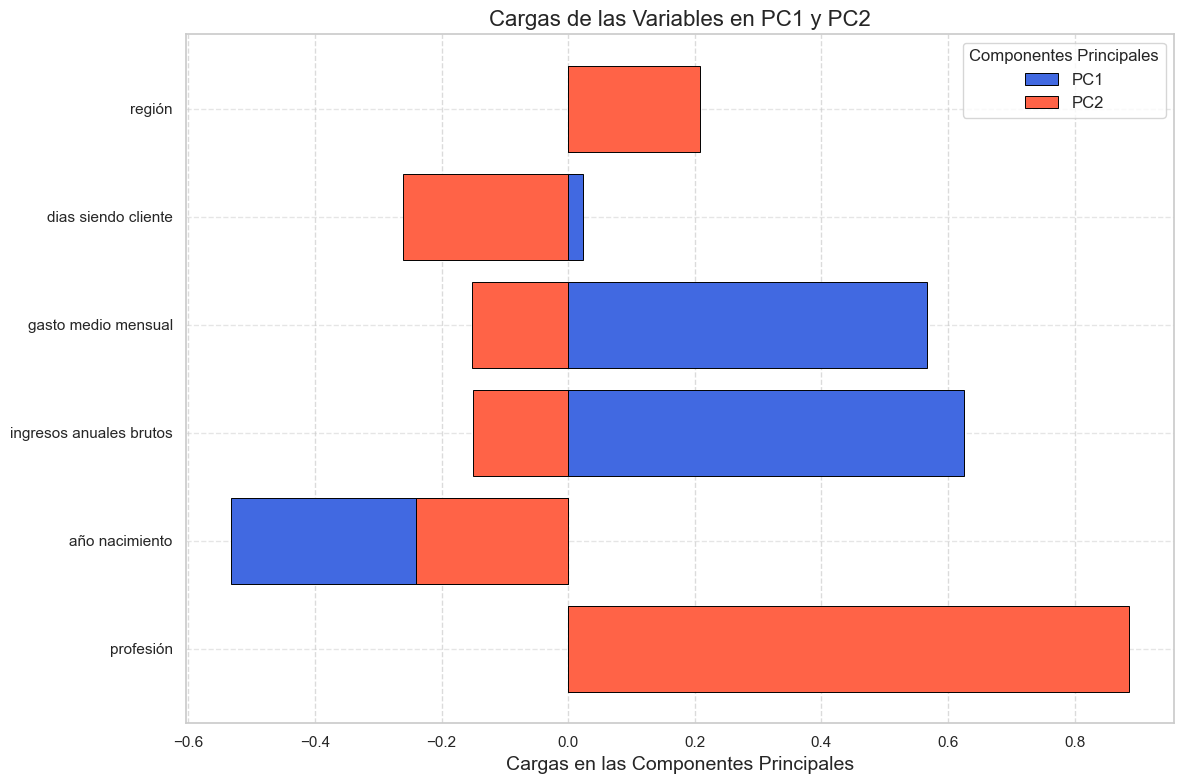

In [406]:
# 📊 Gráfico combinado de Cargas para PC1 y PC2 en un solo gráfico
plt.figure(figsize=(12,8))

# Cargas de PC1 (color azul)
plt.barh(cargas_df.index, cargas_df['PC1'], color='royalblue', edgecolor='black', linewidth=0.7, label='PC1')

# Cargas de PC2 (color rojo)
plt.barh(cargas_df.index, cargas_df['PC2'], color='tomato', edgecolor='black', linewidth=0.7, label='PC2')

# Etiquetas y título
plt.xlabel('Cargas en las Componentes Principales', fontsize=14)
plt.title('Cargas de las Variables en PC1 y PC2', fontsize=16)

# Leyenda
plt.legend(title="Componentes Principales", fontsize=12)

# Configuración de la cuadrícula
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


TypeError: xlabel() missing 1 required positional argument: 'xlabel'

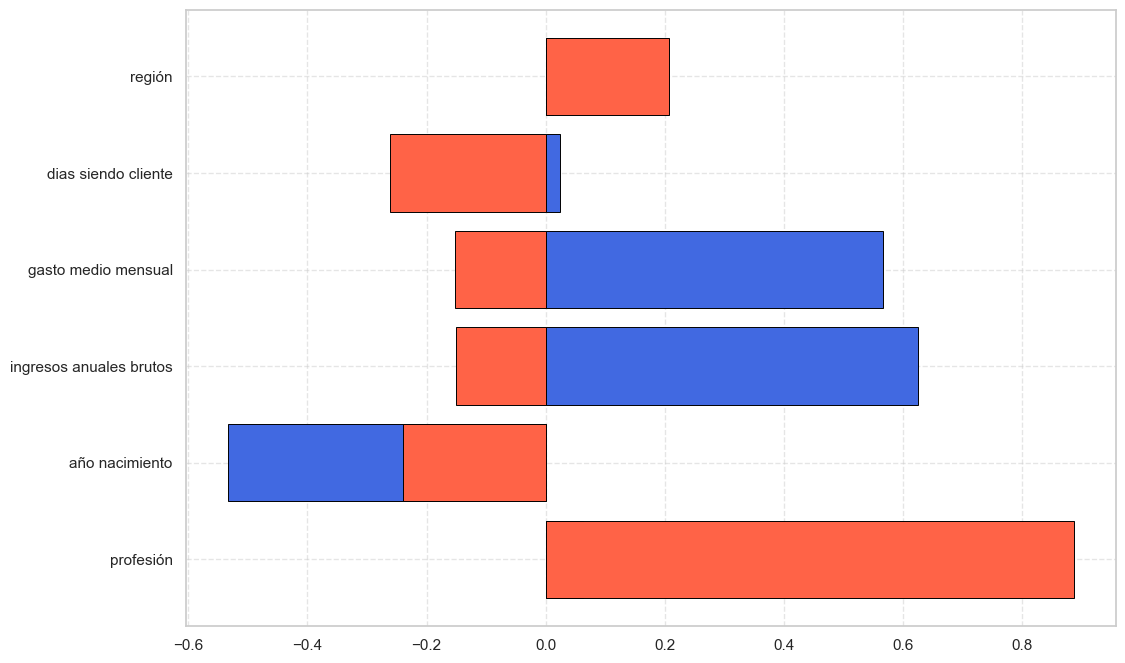

In [411]:
# 📊 Gráfico combinado de Cargas para PC1 y PC2 en un solo gráfico
plt.figure(figsize=(12,8))

# Cargas de PC1 (color azul)
plt.barh(cargas_df.index, cargas_df['PC1'], color='royalblue', edgecolor='black', linewidth=0.7, label='PC1')

# Cargas de PC2 (color rojo)
plt.barh(cargas_df.index, cargas_df['PC2'], color='tomato', edgecolor='black', linewidth=0.7, label='PC2')

# Etiquetas y formato de las letras
plt.xlabel(fontsize=16, fontweight='bold')  # Mayor tamaño y negrita
plt.xticks(fontsize=14, fontweight='bold')  # Tamaño y grosor de las letras de los ticks
plt.yticks(fontsize=14, fontweight='bold')  # Tamaño y grosor de las letras de los ticks

# Remarcar el 0
plt.axvline(0, color='black', linewidth=2, linestyle='--')  # Línea en el 0

# Leyenda
plt.legend(title="Componentes Principales", fontsize=14, fontweight='bold')

# Configuración de la cuadrícula
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


TypeError: Legend.set_title() got an unexpected keyword argument 'fontweight'

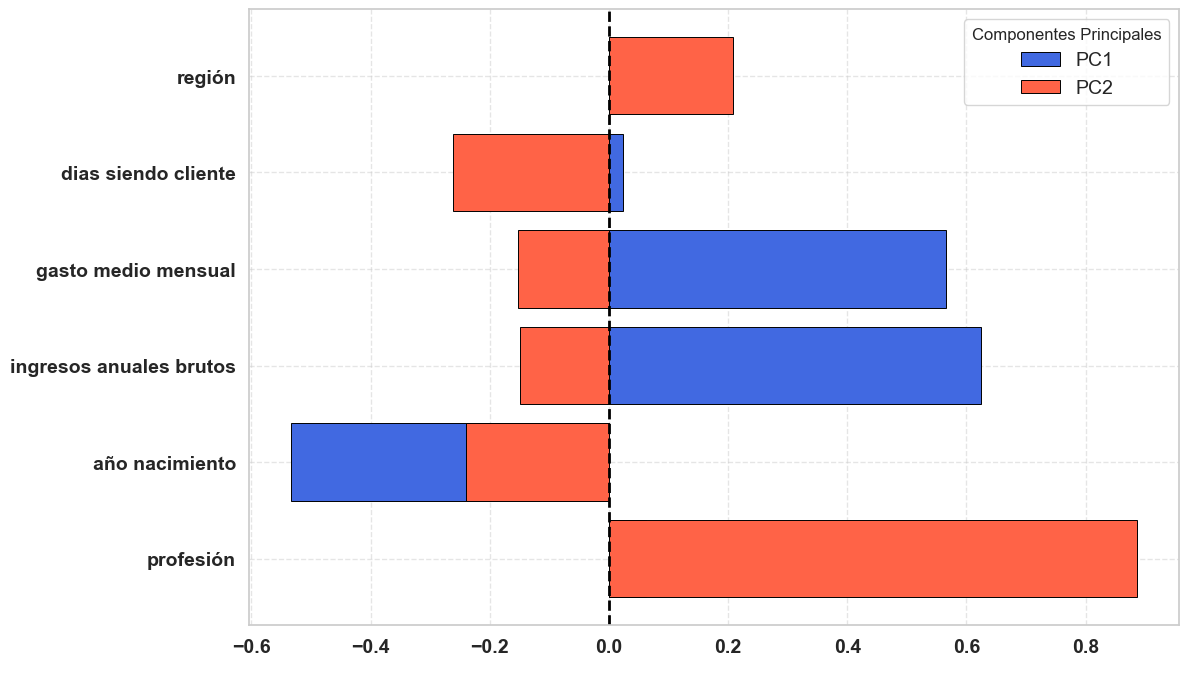

In [415]:
# 📊 Gráfico combinado de Cargas para PC1 y PC2 en un solo gráfico
plt.figure(figsize=(12,8))

# Cargas de PC1 (color azul)
plt.barh(cargas_df.index, cargas_df['PC1'], color='royalblue', edgecolor='black', linewidth=0.7, label='PC1')

# Cargas de PC2 (color rojo)
plt.barh(cargas_df.index, cargas_df['PC2'], color='tomato', edgecolor='black', linewidth=0.7, label='PC2')

# Etiquetas y formato de las letras
plt.xlabel(' ', fontsize=16, fontweight='bold')  # Mayor tamaño y negrita
plt.xticks(fontsize=14, fontweight='bold')  # Tamaño y grosor de las letras de los ticks
plt.yticks(fontsize=14, fontweight='bold')  # Tamaño y grosor de las letras de los ticks

# Remarcar el 0
plt.axvline(0, color='black', linewidth=2, linestyle='--')  # Línea en el 0

# Leyenda
legend = plt.legend(title="Componentes Principales", fontsize=14)
legend.set_title("Componentes Principales", fontweight='bold')  # Cambiar el título de la leyenda a negrita
for label in legend.get_texts():
    label.set_fontweight('bold')  # Poner las etiquetas de la leyenda en negrita

# Configuración de la cuadrícula
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


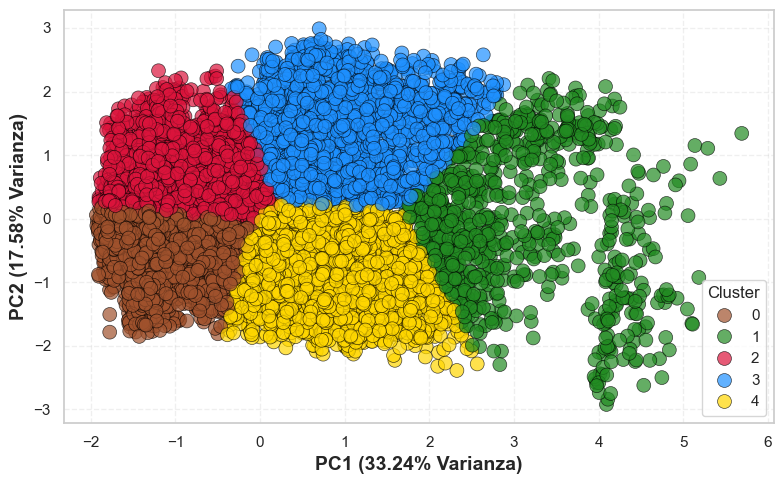

In [425]:
# 📊 Visualizar PCA con Clusters usando colores personalizados
plt.figure(figsize=(8,5))

# Colores personalizados para los clusters
colors = ['#A0522D', '#228B22', '#DC143C', '#1E90FF', '#FFD700']

# Graficar los puntos con colores personalizados para cada cluster
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette=colors, s=100, alpha=0.7, edgecolor='black', linewidth=0.5)

# Etiquetas de los ejes
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)', fontsize=14, fontweight='bold')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)', fontsize=14, fontweight='bold')

# Configuración de la cuadrícula
plt.grid(True, linestyle='--', alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### fin